# Survival analysis

Make a dictionary where we have a table for each cancer type that's ready to plug into the plotter. Format: One column of days until last contact or death (duration col), on column of vital status (event col), and a column of true/false for each event (attribute).

Then plot for each cancer type.

In [2]:
import pandas as pd
import numpy as np
import cptac
import cptac.utils as ut
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

## Prepare tables

In [3]:
dss = {
    "ccrcc": cptac.Ccrcc,
    "endometrial": cptac.Endometrial,
    "hnscc": cptac.Hnscc,
    "lscc": cptac.Lscc,
    "luad": cptac.Luad,
}

In [15]:
def prepare_plot_table(ds):
    
    # Load the followup data
    ds = ds()
    cancer_type = ds.get_cancer_type()
    
    if cancer_type in ["ovarian"]:
        fp = ds.get_clinical()
    else:
        fp = ds.get_followup()
    
    cancer_col_names = {
        "ccrcc": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        },
        "endometrial": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        },
        "hnscc": {
            "vital_status": "VITAL_STATUS",
            "last_contact": "PATHO_DIAG_TO_LAST_CONT_DAYS",
            "death": "PATHO_DIAG_TO_DEATH_DAYS",
        },
        # No followup df or clinical with this info
        "lscc": {
            
        },
        "luad": {
            "vital_status": "Vital Status",
            "last_contact": "Path Diag to Last Contact(Day)",
            "death": "Path Diag to Death(days)",
        }
    }
    
    vital_status_col = cancer_col_names[cancer_type]["vital_status"]
    last_contact_col = cancer_col_names[cancer_type]["last_contact"]
    death_col = cancer_col_names[cancer_type]["death"]
    
    # Rename columns for consistency
    fp = fp[[vital_status_col, last_contact_col, death_col]].\
    rename(columns={
        vital_status_col: "vital_status",
        last_contact_col: "days_to_last_contact",
        death_col: "days_to_death"
    })
    
    # Only keep rows where the death column is not NaN
    fp = fp[fp["vital_status"].notna()]
    
    # Only keep rows where at least one of the days_to_last_contact and days_to_death columns is not NaN
    fp = fp[(fp["days_to_last_contact"].notna() | fp["days_to_death"].notna())]
    
    # Fill NaNs in days_to_last_contact and days_to_death columns with zeros
    fp["days_to_last_contact"] = fp["days_to_last_contact"].fillna(0)
    fp["days_to_death"] = fp["days_to_death"].fillna(0)

    # Take care of multiple entries for each patient
    fp = fp.groupby("Patient_ID").agg(
        death=("vital_status", min), # This will select Deceased over Living
        days_to_last_contact=("days_to_last_contact", max),
        days_to_death=("days_to_death", max)
    )
    
    # Combine the days until last contact and days until death columns
    # We previously replaced NaNs with zeros, so those will be given lowest priority
    fp = fp.assign(days_to_last_contact_or_death=fp["days_to_last_contact"].combine(fp["days_to_death"], max))
    
    # Drop the other two
    fp = fp.drop(columns=["days_to_last_contact", "days_to_death"])
    
    # Fill vals
    fp["death"] = fp["death"].replace({"Deceased": True, "Living": False})
    
    # Load the residuals
    event = pd.read_csv(f"{cancer_type}_residuals.tsv.gz", sep="\t", index_col=0)
    
#     event = event.assign(
#         both=event["8p_loss"] & event["8q_gain"],
#         neither=~(event["8p_loss"] | event["8q_gain"])
#     )
    
    # Join the two
    joined = fp.join(event, how="inner")
    
    # Check
#    assert joined.index.duplicated().sum() == 0
    
    return joined

### Data example

The cell below shows the format we need our data in for the survival analysis. You need three columns:
- Event column (whether they have passed away): Boolean
- Duration column (days until death or last contact): Numeric
- Covariate column (whether each patient had the event): Boolean

In [16]:
prepare_plot_table(cptac.Luad).head()

,death,days_to_last_contact_or_death,Gene,Proteomics,Tissue,Transcriptomics,m,b,orth_resid,intersect_x,intersect_y,above_reg_line
Patient_ID,,,,,,,,,,,,
C3L-00001,False,1065.0,AACS,-1.1998,Tumor,2.6953,3.121565,-9.790151,0.053937,2.746666,-1.216255,True
C3L-00001,False,1065.0,AADAC,-1.6826,Tumor,-3.3578,1.546065,-1.114865,2.511100,-1.249310,-3.046379,True
C3L-00001,False,1065.0,AAGAB,-0.8179,Tumor,3.9955,2.586757,-10.347059,0.290709,3.724347,-0.713077,False
C3L-00001,False,1065.0,AAMDC,-0.8053,Tumor,2.6009,4.773432,-14.420181,0.245981,2.841654,-0.855736,True
C3L-00001,False,1065.0,AAMP,-0.1899,Tumor,5.0072,6.081416,-32.501973,0.301993,5.305191,-0.238900,True


## Plot individual variables

In [22]:
def plot_single_var_survival(cancer_type, df, above_reg_col, gene):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(f"{cancer_type} - {gene}")
    cph.print_summary()
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_event_count = df[above_reg_col].sum()
    no_event_count = df[above_reg_col].size - has_event_count
    
    plot_title = f"{cancer_type} survival: {above_reg_col}\n{deceased_count} deceased, {living_count} living\n {has_event_count} with event, {no_event_count} without event"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=above_reg_col, 
        values=[False, True],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

ccrcc - A                                 


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.91
         time fit was run = 2021-10-05 17:22:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.30       1.36       0.58            -0.84             1.44                 0.43                 4.24

                  z    p   -log2(p)
covariate                          
above_reg_line 0.52 0.60       0.73
---
Concordance = 0.54
Partial AIC = 107.83
log-likelihood ratio test = 0.27 on 1 df
-log2(p) of ll-ratio test = 0.73

ccrcc - A


<lifelines.CoxPHFitter: fitted with 40 total observations, 34 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 40
number of events observed = 6
   partial log-likelihood = -19.73
         time fit was run = 2021-10-05 17:22:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.41       0.25       1.06            -3.49             0.68                 0.03                 1.97

                   z    p   -log2(p)
covariate                           
above_reg_line -1.32 0.19       2.43
---
Concordance = 0.66
Partial AIC = 41.47
log-likelihood ratio test = 2.16 on 1 df
-log2(p) of ll-ratio test = 2.82

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:22:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.16       1.18       0.58            -0.97             1.29                 0.38                 3.64

                  z    p   -log2(p)
covariate                          
above_reg_line 0.28 0.78       0.36
---
Concordance = 0.52
Partial AIC = 108.02
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.51
         time fit was run = 2021-10-05 17:22:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.62       1.86       0.61            -0.57             1.81                 0.56                 6.14

                  z    p   -log2(p)
covariate                          
above_reg_line 1.02 0.31       1.69
---
Concordance = 0.59
Partial AIC = 107.02
log-likelihood ratio test = 1.08 on 1 df
-log2(p) of ll-ratio test = 1.74

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.63
         time fit was run = 2021-10-05 17:22:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.55       1.73       0.61            -0.64             1.74                 0.53                 5.69

                  z    p   -log2(p)
covariate                          
above_reg_line 0.91 0.37       1.45
---
Concordance = 0.56
Partial AIC = 107.25
log-likelihood ratio test = 0.85 on 1 df
-log2(p) of ll-ratio test = 1.48

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.98
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.22       1.25       0.58            -0.92             1.36                 0.40                 3.89

                  z    p   -log2(p)
covariate                          
above_reg_line 0.38 0.70       0.51
---
Concordance = 0.52
Partial AIC = 107.96
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.02       0.98       0.58            -1.16             1.12                 0.31                 3.05

                   z    p   -log2(p)
covariate                           
above_reg_line -0.04 0.97       0.05
---
Concordance = 0.49
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.25
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.75       0.47       0.61            -1.96             0.45                 0.14                 1.57

                   z    p   -log2(p)
covariate                           
above_reg_line -1.22 0.22       2.18
---
Concordance = 0.58
Partial AIC = 106.50
log-likelihood ratio test = 1.60 on 1 df
-log2(p) of ll-ratio test = 2.28

ccrcc - A


<lifelines.CoxPHFitter: fitted with 18 total observations, 16 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 18
number of events observed = 2
   partial log-likelihood = -5.53
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.03       0.97       1.23            -2.44             2.37                 0.09                10.73

                   z    p   -log2(p)
covariate                           
above_reg_line -0.03 0.98       0.03
---
Concordance = 0.53
Partial AIC = 13.06
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.99
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.20       0.82       0.57            -1.33             0.93                 0.27                 2.53

                   z    p   -log2(p)
covariate                           
above_reg_line -0.35 0.73       0.46
---
Concordance = 0.51
Partial AIC = 107.98
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.46

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.75
         time fit was run = 2021-10-05 17:22:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.47       0.63       0.61            -1.66             0.73                 0.19                 2.07

                   z    p   -log2(p)
covariate                           
above_reg_line -0.77 0.44       1.17
---
Concordance = 0.56
Partial AIC = 107.50
log-likelihood ratio test = 0.60 on 1 df
-log2(p) of ll-ratio test = 1.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.77
         time fit was run = 2021-10-05 17:22:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.44       0.65       0.58            -1.58             0.70                 0.21                 2.02

                   z    p   -log2(p)
covariate                           
above_reg_line -0.75 0.45       1.14
---
Concordance = 0.54
Partial AIC = 107.53
log-likelihood ratio test = 0.57 on 1 df
-log2(p) of ll-ratio test = 1.14

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.91
         time fit was run = 2021-10-05 17:22:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.30       1.36       0.58            -0.83             1.44                 0.44                 4.20

                  z    p   -log2(p)
covariate                          
above_reg_line 0.53 0.60       0.74
---
Concordance = 0.54
Partial AIC = 107.83
log-likelihood ratio test = 0.27 on 1 df
-log2(p) of ll-ratio test = 0.73

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:22:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.13       1.14       0.58            -1.00             1.27                 0.37                 3.56

                  z    p   -log2(p)
covariate                          
above_reg_line 0.23 0.82       0.29
---
Concordance = 0.50
Partial AIC = 108.05
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.29

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.41
         time fit was run = 2021-10-05 17:22:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.68       0.51       0.61            -1.87             0.52                 0.15                 1.68

                   z    p   -log2(p)
covariate                           
above_reg_line -1.11 0.27       1.91
---
Concordance = 0.57
Partial AIC = 106.81
log-likelihood ratio test = 1.29 on 1 df
-log2(p) of ll-ratio test = 1.96

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.06       1.06       0.57            -1.07             1.18                 0.34                 3.27

                  z    p   -log2(p)
covariate                          
above_reg_line 0.10 0.92       0.12
---
Concordance = 0.53
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.12

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.79
         time fit was run = 2021-10-05 17:22:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.42       0.66       0.59            -1.59             0.74                 0.20                 2.10

                   z    p   -log2(p)
covariate                           
above_reg_line -0.71 0.48       1.06
---
Concordance = 0.54
Partial AIC = 107.57
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.88
         time fit was run = 2021-10-05 17:22:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.34       1.40       0.59            -0.82             1.49                 0.44                 4.44

                  z    p   -log2(p)
covariate                          
above_reg_line 0.57 0.57       0.82
---
Concordance = 0.54
Partial AIC = 107.76
log-likelihood ratio test = 0.34 on 1 df
-log2(p) of ll-ratio test = 0.83

ccrcc - A


<lifelines.CoxPHFitter: fitted with 38 total observations, 31 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 38
number of events observed = 7
   partial log-likelihood = -24.64
         time fit was run = 2021-10-05 17:22:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.04       1.04       0.74            -1.40             1.49                 0.25                 4.44

                  z    p   -log2(p)
covariate                          
above_reg_line 0.06 0.95       0.07
---
Concordance = 0.51
Partial AIC = 51.28
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

ccrcc - A


<lifelines.CoxPHFitter: fitted with 77 total observations, 67 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 77
number of events observed = 10
   partial log-likelihood = -40.53
         time fit was run = 2021-10-05 17:22:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.17       1.18       0.62            -1.05             1.38                 0.35                 3.98

                  z    p   -log2(p)
covariate                          
above_reg_line 0.27 0.79       0.34
---
Concordance = 0.52
Partial AIC = 83.07
log-likelihood ratio test = 0.07 on 1 df
-log2(p) of ll-ratio test = 0.34

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:22:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.13       1.13       0.58            -1.01             1.26                 0.36                 3.54

                  z    p   -log2(p)
covariate                          
above_reg_line 0.22 0.83       0.27
---
Concordance = 0.50
Partial AIC = 108.05
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27

ccrcc - A


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:947: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axes = kwargs.pop("ax", None) or plt.figure().add_subplot(111)


<lifelines.CoxPHFitter: fitted with 150 total observations, 132 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 150
number of events observed = 18
   partial log-likelihood = -82.10
         time fit was run = 2021-10-05 17:22:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.97       2.65       0.52            -0.05             2.00                 0.95                 7.41

                  z    p   -log2(p)
covariate                          
above_reg_line 1.86 0.06       3.98
---
Concordance = 0.50
Partial AIC = 166.20
log-likelihood ratio test = 3.83 on 1 df
-log2(p) of ll-ratio test = 4.32

ccrcc - A


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/utils/__init__.py:1116: ConvergenceWarning: Column above_reg_line have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'above_reg_line'].var())
>>> print(df.loc[~events, 'above_reg_line'].var())

A very low variance means that the column above_reg_line completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.503. This may imply 

<lifelines.CoxPHFitter: fitted with 52 total observations, 47 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 52
number of events observed = 5
   partial log-likelihood = -14.78
         time fit was run = 2021-10-05 17:22:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line -18.10       0.00       0.48           -19.04           -17.16                 0.00                 0.00

                    z      p   -log2(p)
covariate                              
above_reg_line -37.73 <0.005    1032.52
---
Concordance = 0.78
Partial AIC = 31.56
log-likelihood ratio test = 7.78 on 1 df
-log2(p) of ll-ratio test = 7.56

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.99
         time fit was run = 2021-10-05 17:22:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.19       0.82       0.58            -1.33             0.94                 0.26                 2.56

                   z    p   -log2(p)
covariate                           
above_reg_line -0.33 0.74       0.44
---
Concordance = 0.52
Partial AIC = 107.99
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.44

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.15
         time fit was run = 2021-10-05 17:22:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.21       0.30       0.66            -2.50             0.09                 0.08                 1.10

                   z    p   -log2(p)
covariate                           
above_reg_line -1.82 0.07       3.86
---
Concordance = 0.64
Partial AIC = 104.30
log-likelihood ratio test = 3.80 on 1 df
-log2(p) of ll-ratio test = 4.29

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.71
         time fit was run = 2021-10-05 17:22:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.48       0.62       0.58            -1.62             0.67                 0.20                 1.95

                   z    p   -log2(p)
covariate                           
above_reg_line -0.82 0.41       1.27
---
Concordance = 0.57
Partial AIC = 107.43
log-likelihood ratio test = 0.67 on 1 df
-log2(p) of ll-ratio test = 1.28

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.41
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.67       1.96       0.61            -0.51             1.86                 0.60                 6.44

                  z    p   -log2(p)
covariate                          
above_reg_line 1.11 0.27       1.91
---
Concordance = 0.59
Partial AIC = 106.82
log-likelihood ratio test = 1.28 on 1 df
-log2(p) of ll-ratio test = 1.96

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.05       0.95       0.58            -1.18             1.08                 0.31                 2.93

                   z    p   -log2(p)
covariate                           
above_reg_line -0.09 0.93       0.11
---
Concordance = 0.51
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.46
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.10       0.33       0.66            -2.40             0.20                 0.09                 1.22

                   z    p   -log2(p)
covariate                           
above_reg_line -1.67 0.10       3.38
---
Concordance = 0.62
Partial AIC = 104.93
log-likelihood ratio test = 3.17 on 1 df
-log2(p) of ll-ratio test = 3.74

ccrcc - A


<lifelines.CoxPHFitter: fitted with 133 total observations, 119 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 133
number of events observed = 14
   partial log-likelihood = -64.54
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.06       0.95       0.53            -1.09             0.98                 0.34                 2.67

                   z    p   -log2(p)
covariate                           
above_reg_line -0.11 0.92       0.13
---
Concordance = 0.50
Partial AIC = 131.07
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.12

ccrcc - A


<lifelines.CoxPHFitter: fitted with 106 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 106
number of events observed = 12
   partial log-likelihood = -52.39
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.40       1.49       0.58            -0.74             1.54                 0.48                 4.66

                  z    p   -log2(p)
covariate                          
above_reg_line 0.69 0.49       1.02
---
Concordance = 0.54
Partial AIC = 106.78
log-likelihood ratio test = 0.47 on 1 df
-log2(p) of ll-ratio test = 1.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:22:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.14       0.87       0.57            -1.26             0.98                 0.28                 2.66

                   z    p   -log2(p)
covariate                           
above_reg_line -0.25 0.80       0.32
---
Concordance = 0.53
Partial AIC = 108.04
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.31

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.02       1.02       0.57            -1.09             1.14                 0.33                 3.13

                  z    p   -log2(p)
covariate                          
above_reg_line 0.04 0.97       0.05
---
Concordance = 0.49
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.77
         time fit was run = 2021-10-05 17:22:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.45       0.64       0.61            -1.63             0.74                 0.20                 2.09

                   z    p   -log2(p)
covariate                           
above_reg_line -0.74 0.46       1.12
---
Concordance = 0.55
Partial AIC = 107.55
log-likelihood ratio test = 0.55 on 1 df
-log2(p) of ll-ratio test = 1.13

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -49.67
         time fit was run = 2021-10-05 17:22:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.72       0.18       0.77            -3.23            -0.21                 0.04                 0.81

                   z    p   -log2(p)
covariate                           
above_reg_line -2.24 0.03       5.31
---
Concordance = 0.69
Partial AIC = 101.34
log-likelihood ratio test = 6.76 on 1 df
-log2(p) of ll-ratio test = 6.74

ccrcc - A


<lifelines.CoxPHFitter: fitted with 220 total observations, 196 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 220
number of events observed = 24
   partial log-likelihood = -122.59
         time fit was run = 2021-10-05 17:22:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.15       1.16       0.41            -0.65             0.95                 0.52                 2.58

                  z    p   -log2(p)
covariate                          
above_reg_line 0.37 0.71       0.49
---
Concordance = 0.50
Partial AIC = 247.19
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.49

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.61
         time fit was run = 2021-10-05 17:22:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.05       0.35       0.66            -2.36             0.25                 0.09                 1.28

                   z    p   -log2(p)
covariate                           
above_reg_line -1.59 0.11       3.15
---
Concordance = 0.62
Partial AIC = 105.23
log-likelihood ratio test = 2.87 on 1 df
-log2(p) of ll-ratio test = 3.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 101 total observations, 91 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 101
number of events observed = 10
   partial log-likelihood = -42.86
         time fit was run = 2021-10-05 17:22:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.61       0.54       0.69            -1.96             0.73                 0.14                 2.08

                   z    p   -log2(p)
covariate                           
above_reg_line -0.89 0.37       1.42
---
Concordance = 0.58
Partial AIC = 87.71
log-likelihood ratio test = 0.85 on 1 df
-log2(p) of ll-ratio test = 1.48

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.01       0.99       0.57            -1.13             1.10                 0.32                 3.02

                   z    p   -log2(p)
covariate                           
above_reg_line -0.03 0.98       0.03
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.35
         time fit was run = 2021-10-05 17:22:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.14       0.32       0.66            -2.43             0.15                 0.09                 1.16

                   z    p   -log2(p)
covariate                           
above_reg_line -1.74 0.08       3.61
---
Concordance = 0.64
Partial AIC = 104.70
log-likelihood ratio test = 3.40 on 1 df
-log2(p) of ll-ratio test = 3.94

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.03       0.97       0.57            -1.15             1.09                 0.32                 2.98

                   z    p   -log2(p)
covariate                           
above_reg_line -0.05 0.96       0.06
---
Concordance = 0.53
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.06

ccrcc - A


<lifelines.CoxPHFitter: fitted with 201 total observations, 177 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 201
number of events observed = 24
   partial log-likelihood = -120.44
         time fit was run = 2021-10-05 17:22:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.34       0.71       0.42            -1.16             0.48                 0.31                 1.62

                   z    p   -log2(p)
covariate                           
above_reg_line -0.81 0.42       1.26
---
Concordance = 0.50
Partial AIC = 242.89
log-likelihood ratio test = 0.67 on 1 df
-log2(p) of ll-ratio test = 1.27

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.00       1.00       0.58            -1.13             1.13                 0.32                 3.11

                  z    p   -log2(p)
covariate                          
above_reg_line 0.01 1.00       0.01
---
Concordance = 0.51
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.83
         time fit was run = 2021-10-05 17:22:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.39       0.68       0.58            -1.53             0.75                 0.22                 2.12

                   z    p   -log2(p)
covariate                           
above_reg_line -0.67 0.50       0.99
---
Concordance = 0.54
Partial AIC = 107.65
log-likelihood ratio test = 0.45 on 1 df
-log2(p) of ll-ratio test = 0.99

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.96
         time fit was run = 2021-10-05 17:22:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.25       1.28       0.58            -0.89             1.38                 0.41                 3.99

                  z    p   -log2(p)
covariate                          
above_reg_line 0.43 0.67       0.58
---
Concordance = 0.51
Partial AIC = 107.92
log-likelihood ratio test = 0.18 on 1 df
-log2(p) of ll-ratio test = 0.58

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.06       1.07       0.58            -1.07             1.20                 0.34                 3.32

                  z    p   -log2(p)
covariate                          
above_reg_line 0.11 0.91       0.13
---
Concordance = 0.49
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.13

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.53
         time fit was run = 2021-10-05 17:22:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.08       0.34       0.65            -2.36             0.19                 0.09                 1.21

                   z    p   -log2(p)
covariate                           
above_reg_line -1.67 0.09       3.40
---
Concordance = 0.64
Partial AIC = 105.05
log-likelihood ratio test = 3.05 on 1 df
-log2(p) of ll-ratio test = 3.63

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.51
         time fit was run = 2021-10-05 17:22:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.62       0.54       0.61            -1.81             0.57                 0.16                 1.77

                   z    p   -log2(p)
covariate                           
above_reg_line -1.02 0.31       1.71
---
Concordance = 0.58
Partial AIC = 107.01
log-likelihood ratio test = 1.09 on 1 df
-log2(p) of ll-ratio test = 1.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.99
         time fit was run = 2021-10-05 17:22:23 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.20       1.22       0.59            -0.95             1.35                 0.39                 3.87

                  z    p   -log2(p)
covariate                          
above_reg_line 0.34 0.73       0.45
---
Concordance = 0.53
Partial AIC = 107.98
log-likelihood ratio test = 0.12 on 1 df
-log2(p) of ll-ratio test = 0.45

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.61
         time fit was run = 2021-10-05 17:22:24 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.54       0.58       0.58            -1.68             0.59                 0.19                 1.81

                   z    p   -log2(p)
covariate                           
above_reg_line -0.94 0.35       1.52
---
Concordance = 0.57
Partial AIC = 107.23
log-likelihood ratio test = 0.87 on 1 df
-log2(p) of ll-ratio test = 1.51

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.20
         time fit was run = 2021-10-05 17:22:24 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.77       0.46       0.61            -1.96             0.41                 0.14                 1.51

                   z    p   -log2(p)
covariate                           
above_reg_line -1.28 0.20       2.31
---
Concordance = 0.59
Partial AIC = 106.40
log-likelihood ratio test = 1.70 on 1 df
-log2(p) of ll-ratio test = 2.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.27
         time fit was run = 2021-10-05 17:22:24 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.74       2.10       0.61            -0.46             1.94                 0.63                 6.96

                  z    p   -log2(p)
covariate                          
above_reg_line 1.21 0.22       2.15
---
Concordance = 0.59
Partial AIC = 106.54
log-likelihood ratio test = 1.56 on 1 df
-log2(p) of ll-ratio test = 2.24

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.80
         time fit was run = 2021-10-05 17:22:24 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.41       0.66       0.58            -1.54             0.72                 0.21                 2.05

                   z    p   -log2(p)
covariate                           
above_reg_line -0.71 0.48       1.07
---
Concordance = 0.56
Partial AIC = 107.60
log-likelihood ratio test = 0.50 on 1 df
-log2(p) of ll-ratio test = 1.05

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.68
         time fit was run = 2021-10-05 17:22:24 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.50       1.65       0.58            -0.64             1.65                 0.53                 5.18

                  z    p   -log2(p)
covariate                          
above_reg_line 0.86 0.39       1.35
---
Concordance = 0.56
Partial AIC = 107.36
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:22:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.17       1.18       0.57            -0.94             1.28                 0.39                 3.59

                  z    p   -log2(p)
covariate                          
above_reg_line 0.30 0.77       0.38
---
Concordance = 0.54
Partial AIC = 108.01
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.84
         time fit was run = 2021-10-05 17:22:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.37       0.69       0.57            -1.49             0.75                 0.22                 2.11

                   z    p   -log2(p)
covariate                           
above_reg_line -0.65 0.51       0.96
---
Concordance = 0.52
Partial AIC = 107.69
log-likelihood ratio test = 0.41 on 1 df
-log2(p) of ll-ratio test = 0.94

ccrcc - A


<lifelines.CoxPHFitter: fitted with 220 total observations, 196 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 220
number of events observed = 24
   partial log-likelihood = -122.66
         time fit was run = 2021-10-05 17:22:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.02       1.02       0.41            -0.78             0.82                 0.46                 2.27

                  z    p   -log2(p)
covariate                          
above_reg_line 0.05 0.96       0.06
---
Concordance = 0.50
Partial AIC = 247.32
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.06

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.09       1.09       0.58            -1.04             1.22                 0.35                 3.39

                  z    p   -log2(p)
covariate                          
above_reg_line 0.15 0.88       0.19
---
Concordance = 0.50
Partial AIC = 108.08
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:22:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.18       1.20       0.57            -0.93             1.30                 0.39                 3.66

                  z    p   -log2(p)
covariate                          
above_reg_line 0.32 0.75       0.42
---
Concordance = 0.53
Partial AIC = 108.00
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.41

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.20
         time fit was run = 2021-10-05 17:22:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.32       3.73       0.77            -0.18             2.81                 0.83                16.69

                  z    p   -log2(p)
covariate                          
above_reg_line 1.72 0.09       3.54
---
Concordance = 0.63
Partial AIC = 104.39
log-likelihood ratio test = 3.71 on 1 df
-log2(p) of ll-ratio test = 4.21

ccrcc - A


<lifelines.CoxPHFitter: fitted with 80 total observations, 71 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 80
number of events observed = 9
   partial log-likelihood = -36.48
         time fit was run = 2021-10-05 17:22:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.09       2.97       0.79            -0.45             2.63                 0.64                13.91

                  z    p   -log2(p)
covariate                          
above_reg_line 1.38 0.17       2.59
---
Concordance = 0.62
Partial AIC = 74.97
log-likelihood ratio test = 2.19 on 1 df
-log2(p) of ll-ratio test = 2.85

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 81 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 11
   partial log-likelihood = -46.48
         time fit was run = 2021-10-05 17:22:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.41       0.66       0.61            -1.61             0.78                 0.20                 2.19

                   z    p   -log2(p)
covariate                           
above_reg_line -0.68 0.50       1.00
---
Concordance = 0.56
Partial AIC = 94.96
log-likelihood ratio test = 0.45 on 1 df
-log2(p) of ll-ratio test = 0.99

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -49.37
         time fit was run = 2021-10-05 17:22:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.79       6.00       0.76             0.31             3.27                 1.36                26.38

                  z    p   -log2(p)
covariate                          
above_reg_line 2.37 0.02       5.82
---
Concordance = 0.70
Partial AIC = 100.74
log-likelihood ratio test = 7.36 on 1 df
-log2(p) of ll-ratio test = 7.23

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.78
         time fit was run = 2021-10-05 17:22:26 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.99       0.37       0.66            -2.29             0.31                 0.10                 1.36

                   z    p   -log2(p)
covariate                           
above_reg_line -1.50 0.13       2.90
---
Concordance = 0.61
Partial AIC = 105.56
log-likelihood ratio test = 2.54 on 1 df
-log2(p) of ll-ratio test = 3.17

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.66
         time fit was run = 2021-10-05 17:22:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.53       0.59       0.59            -1.69             0.64                 0.18                 1.90

                   z    p   -log2(p)
covariate                           
above_reg_line -0.88 0.38       1.41
---
Concordance = 0.58
Partial AIC = 107.33
log-likelihood ratio test = 0.77 on 1 df
-log2(p) of ll-ratio test = 1.40

ccrcc - A


<lifelines.CoxPHFitter: fitted with 106 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 106
number of events observed = 12
   partial log-likelihood = -52.36
         time fit was run = 2021-10-05 17:22:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.36       0.69       0.61            -1.57             0.84                 0.21                 2.31

                   z    p   -log2(p)
covariate                           
above_reg_line -0.59 0.55       0.86
---
Concordance = 0.56
Partial AIC = 106.71
log-likelihood ratio test = 0.37 on 1 df
-log2(p) of ll-ratio test = 0.88

ccrcc - A


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.502. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 39 total observations, 38 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 39
number of events observed = 1
   partial log-likelihood = -3.00
         time fit was run = 2021-10-05 17:22:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line -15.65       0.00       1.01           -17.63           -13.67                 0.00                 0.00

                    z      p   -log2(p)
covariate                              
above_reg_line -15.48 <0.005     177.24
---
Concordance = 0.71
Partial AIC = 7.99
log-likelihood ratio test = 1.06 on 1 df
-log2(p) of ll-ratio test = 1.72

ccrcc - A


<lifelines.CoxPHFitter: fitted with 88 total observations, 76 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 88
number of events observed = 12
   partial log-likelihood = -50.36
         time fit was run = 2021-10-05 17:22:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.37       1.44       0.58            -0.77             1.50                 0.46                 4.50

                  z    p   -log2(p)
covariate                          
above_reg_line 0.63 0.53       0.92
---
Concordance = 0.55
Partial AIC = 102.71
log-likelihood ratio test = 0.40 on 1 df
-log2(p) of ll-ratio test = 0.92

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.98
         time fit was run = 2021-10-05 17:22:27 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.23       1.25       0.58            -0.92             1.37                 0.40                 3.94

                  z    p   -log2(p)
covariate                          
above_reg_line 0.38 0.70       0.51
---
Concordance = 0.53
Partial AIC = 107.95
log-likelihood ratio test = 0.15 on 1 df
-log2(p) of ll-ratio test = 0.52

ccrcc - A


<lifelines.CoxPHFitter: fitted with 43 total observations, 40 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 43
number of events observed = 3
   partial log-likelihood = -9.45
         time fit was run = 2021-10-05 17:22:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.44       4.21       1.01            -0.54             3.42                 0.58                30.47

                  z    p   -log2(p)
covariate                          
above_reg_line 1.42 0.15       2.69
---
Concordance = 0.72
Partial AIC = 20.91
log-likelihood ratio test = 1.45 on 1 df
-log2(p) of ll-ratio test = 2.13

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -48.65
         time fit was run = 2021-10-05 17:22:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.94       0.14       0.78            -3.48            -0.41                 0.03                 0.67

                   z    p   -log2(p)
covariate                           
above_reg_line -2.48 0.01       6.24
---
Concordance = 0.70
Partial AIC = 99.30
log-likelihood ratio test = 8.80 on 1 df
-log2(p) of ll-ratio test = 8.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.91
         time fit was run = 2021-10-05 17:22:28 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.94       0.39       0.65            -2.22             0.33                 0.11                 1.39

                   z    p   -log2(p)
covariate                           
above_reg_line -1.45 0.15       2.77
---
Concordance = 0.64
Partial AIC = 105.82
log-likelihood ratio test = 2.28 on 1 df
-log2(p) of ll-ratio test = 2.94

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.04
         time fit was run = 2021-10-05 17:22:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.84       2.32       0.60            -0.33             2.01                 0.72                 7.49

                  z    p   -log2(p)
covariate                          
above_reg_line 1.41 0.16       2.66
---
Concordance = 0.61
Partial AIC = 106.09
log-likelihood ratio test = 2.01 on 1 df
-log2(p) of ll-ratio test = 2.68

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.68
         time fit was run = 2021-10-05 17:22:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.50       0.61       0.58            -1.63             0.63                 0.20                 1.88

                   z    p   -log2(p)
covariate                           
above_reg_line -0.87 0.39       1.37
---
Concordance = 0.57
Partial AIC = 107.36
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.86
         time fit was run = 2021-10-05 17:22:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.36       1.44       0.58            -0.77             1.49                 0.46                 4.44

                  z    p   -log2(p)
covariate                          
above_reg_line 0.63 0.53       0.92
---
Concordance = 0.54
Partial AIC = 107.71
log-likelihood ratio test = 0.39 on 1 df
-log2(p) of ll-ratio test = 0.90

ccrcc - A


<lifelines.CoxPHFitter: fitted with 47 total observations, 40 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 47
number of events observed = 7
   partial log-likelihood = -25.36
         time fit was run = 2021-10-05 17:22:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.02       0.98       0.74            -1.48             1.44                 0.23                 4.21

                   z    p   -log2(p)
covariate                           
above_reg_line -0.03 0.98       0.04
---
Concordance = 0.50
Partial AIC = 52.72
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.92
         time fit was run = 2021-10-05 17:22:29 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.89       0.41       0.60            -2.07             0.29                 0.13                 1.34

                   z    p   -log2(p)
covariate                           
above_reg_line -1.48 0.14       2.84
---
Concordance = 0.63
Partial AIC = 105.83
log-likelihood ratio test = 2.27 on 1 df
-log2(p) of ll-ratio test = 2.92

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.69
         time fit was run = 2021-10-05 17:22:30 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.51       0.60       0.62            -1.71             0.70                 0.18                 2.02

                   z    p   -log2(p)
covariate                           
above_reg_line -0.82 0.41       1.28
---
Concordance = 0.56
Partial AIC = 107.39
log-likelihood ratio test = 0.71 on 1 df
-log2(p) of ll-ratio test = 1.33

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.92
         time fit was run = 2021-10-05 17:22:30 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.29       1.34       0.57            -0.83             1.42                 0.44                 4.14

                  z    p   -log2(p)
covariate                          
above_reg_line 0.51 0.61       0.72
---
Concordance = 0.56
Partial AIC = 107.84
log-likelihood ratio test = 0.26 on 1 df
-log2(p) of ll-ratio test = 0.71

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:22:30 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.17       1.18       0.56            -0.94             1.27                 0.39                 3.58

                  z    p   -log2(p)
covariate                          
above_reg_line 0.30 0.77       0.38
---
Concordance = 0.52
Partial AIC = 108.02
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.37

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.22
         time fit was run = 2021-10-05 17:22:31 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.76       0.47       0.61            -1.96             0.43                 0.14                 1.54

                   z    p   -log2(p)
covariate                           
above_reg_line -1.25 0.21       2.25
---
Concordance = 0.59
Partial AIC = 106.45
log-likelihood ratio test = 1.65 on 1 df
-log2(p) of ll-ratio test = 2.33

ccrcc - A


<lifelines.CoxPHFitter: fitted with 25 total observations, 20 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 25
number of events observed = 5
   partial log-likelihood = -14.51
         time fit was run = 2021-10-05 17:22:31 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.16       3.18       1.11            -1.01             3.33                 0.36                27.80

                  z    p   -log2(p)
covariate                          
above_reg_line 1.04 0.30       1.75
---
Concordance = 0.62
Partial AIC = 31.01
log-likelihood ratio test = 1.30 on 1 df
-log2(p) of ll-ratio test = 1.98

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.89
         time fit was run = 2021-10-05 17:22:31 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.34       0.71       0.60            -1.52             0.84                 0.22                 2.31

                   z    p   -log2(p)
covariate                           
above_reg_line -0.57 0.57       0.81
---
Concordance = 0.55
Partial AIC = 107.78
log-likelihood ratio test = 0.32 on 1 df
-log2(p) of ll-ratio test = 0.81

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.70
         time fit was run = 2021-10-05 17:22:31 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.49       1.63       0.58            -0.65             1.62                 0.52                 5.07

                  z    p   -log2(p)
covariate                          
above_reg_line 0.84 0.40       1.32
---
Concordance = 0.56
Partial AIC = 107.40
log-likelihood ratio test = 0.70 on 1 df
-log2(p) of ll-ratio test = 1.32

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:32 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.02       1.03       0.58            -1.11             1.16                 0.33                 3.18

                  z    p   -log2(p)
covariate                          
above_reg_line 0.04 0.97       0.05
---
Concordance = 0.48
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05

ccrcc - A


<lifelines.CoxPHFitter: fitted with 105 total observations, 95 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 105
number of events observed = 10
   partial log-likelihood = -43.22
         time fit was run = 2021-10-05 17:22:32 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.55       1.73       0.65            -0.72             1.81                 0.49                 6.13

                  z    p   -log2(p)
covariate                          
above_reg_line 0.84 0.40       1.33
---
Concordance = 0.55
Partial AIC = 88.45
log-likelihood ratio test = 0.73 on 1 df
-log2(p) of ll-ratio test = 1.35

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.42
         time fit was run = 2021-10-05 17:22:32 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.12       3.06       0.66            -0.18             2.42                 0.83                11.24

                  z    p   -log2(p)
covariate                          
above_reg_line 1.69 0.09       3.45
---
Concordance = 0.62
Partial AIC = 104.84
log-likelihood ratio test = 3.26 on 1 df
-log2(p) of ll-ratio test = 3.82

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.61
         time fit was run = 2021-10-05 17:22:33 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.55       0.58       0.59            -1.69             0.60                 0.18                 1.82

                   z    p   -log2(p)
covariate                           
above_reg_line -0.93 0.35       1.51
---
Concordance = 0.55
Partial AIC = 107.21
log-likelihood ratio test = 0.89 on 1 df
-log2(p) of ll-ratio test = 1.53

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.91
         time fit was run = 2021-10-05 17:22:33 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.31       0.73       0.57            -1.43             0.81                 0.24                 2.25

                   z    p   -log2(p)
covariate                           
above_reg_line -0.54 0.59       0.76
---
Concordance = 0.55
Partial AIC = 107.82
log-likelihood ratio test = 0.28 on 1 df
-log2(p) of ll-ratio test = 0.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.90
         time fit was run = 2021-10-05 17:22:33 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.33       0.72       0.60            -1.52             0.85                 0.22                 2.34

                   z    p   -log2(p)
covariate                           
above_reg_line -0.55 0.58       0.79
---
Concordance = 0.55
Partial AIC = 107.79
log-likelihood ratio test = 0.31 on 1 df
-log2(p) of ll-ratio test = 0.79

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:22:34 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.11       0.89       0.58            -1.26             1.03                 0.28                 2.80

                   z    p   -log2(p)
covariate                           
above_reg_line -0.19 0.85       0.24
---
Concordance = 0.53
Partial AIC = 108.06
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.24

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.96
         time fit was run = 2021-10-05 17:22:34 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.87       0.42       0.61            -2.08             0.33                 0.13                 1.39

                   z    p   -log2(p)
covariate                           
above_reg_line -1.42 0.15       2.69
---
Concordance = 0.60
Partial AIC = 105.93
log-likelihood ratio test = 2.17 on 1 df
-log2(p) of ll-ratio test = 2.83

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.49
         time fit was run = 2021-10-05 17:22:34 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.63       0.53       0.61            -1.83             0.56                 0.16                 1.75

                   z    p   -log2(p)
covariate                           
above_reg_line -1.04 0.30       1.74
---
Concordance = 0.56
Partial AIC = 106.97
log-likelihood ratio test = 1.13 on 1 df
-log2(p) of ll-ratio test = 1.80

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.26
         time fit was run = 2021-10-05 17:22:34 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.75       0.47       0.60            -1.93             0.44                 0.14                 1.55

                   z    p   -log2(p)
covariate                           
above_reg_line -1.24 0.22       2.21
---
Concordance = 0.59
Partial AIC = 106.51
log-likelihood ratio test = 1.59 on 1 df
-log2(p) of ll-ratio test = 2.27

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.77
         time fit was run = 2021-10-05 17:22:35 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.43       0.65       0.58            -1.57             0.70                 0.21                 2.02

                   z    p   -log2(p)
covariate                           
above_reg_line -0.75 0.46       1.13
---
Concordance = 0.57
Partial AIC = 107.55
log-likelihood ratio test = 0.55 on 1 df
-log2(p) of ll-ratio test = 1.13

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 80 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 12
   partial log-likelihood = -48.27
         time fit was run = 2021-10-05 17:22:35 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.63       0.20       0.77            -3.14            -0.12                 0.04                 0.89

                   z    p   -log2(p)
covariate                           
above_reg_line -2.12 0.03       4.87
---
Concordance = 0.67
Partial AIC = 98.54
log-likelihood ratio test = 5.98 on 1 df
-log2(p) of ll-ratio test = 6.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 56 total observations, 47 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 56
number of events observed = 9
   partial log-likelihood = -33.91
         time fit was run = 2021-10-05 17:22:35 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.47       0.63       0.69            -1.82             0.88                 0.16                 2.42

                   z    p   -log2(p)
covariate                           
above_reg_line -0.68 0.50       1.01
---
Concordance = 0.55
Partial AIC = 69.83
log-likelihood ratio test = 0.46 on 1 df
-log2(p) of ll-ratio test = 1.00

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 80 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 12
   partial log-likelihood = -50.35
         time fit was run = 2021-10-05 17:22:35 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.80       0.45       0.61            -1.99             0.39                 0.14                 1.47

                   z    p   -log2(p)
covariate                           
above_reg_line -1.32 0.19       2.43
---
Concordance = 0.59
Partial AIC = 102.69
log-likelihood ratio test = 1.83 on 1 df
-log2(p) of ll-ratio test = 2.51

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.78
         time fit was run = 2021-10-05 17:22:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.43       0.65       0.57            -1.55             0.70                 0.21                 2.01

                   z    p   -log2(p)
covariate                           
above_reg_line -0.74 0.46       1.13
---
Concordance = 0.56
Partial AIC = 107.56
log-likelihood ratio test = 0.54 on 1 df
-log2(p) of ll-ratio test = 1.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 114 total observations, 102 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 114
number of events observed = 12
   partial log-likelihood = -53.24
         time fit was run = 2021-10-05 17:22:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.47       0.62       0.58            -1.61             0.67                 0.20                 1.95

                   z    p   -log2(p)
covariate                           
above_reg_line -0.81 0.42       1.26
---
Concordance = 0.50
Partial AIC = 108.48
log-likelihood ratio test = 0.66 on 1 df
-log2(p) of ll-ratio test = 1.26

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.09       1.09       0.57            -1.03             1.21                 0.36                 3.34

                  z    p   -log2(p)
covariate                          
above_reg_line 0.16 0.88       0.19
---
Concordance = 0.51
Partial AIC = 108.08
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.92
         time fit was run = 2021-10-05 17:22:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.30       0.74       0.58            -1.43             0.83                 0.24                 2.30

                   z    p   -log2(p)
covariate                           
above_reg_line -0.52 0.61       0.72
---
Concordance = 0.55
Partial AIC = 107.84
log-likelihood ratio test = 0.26 on 1 df
-log2(p) of ll-ratio test = 0.72

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.35
         time fit was run = 2021-10-05 17:22:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.71       2.03       0.61            -0.48             1.90                 0.62                 6.66

                  z    p   -log2(p)
covariate                          
above_reg_line 1.16 0.24       2.03
---
Concordance = 0.58
Partial AIC = 106.69
log-likelihood ratio test = 1.41 on 1 df
-log2(p) of ll-ratio test = 2.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.97
         time fit was run = 2021-10-05 17:22:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.23       1.26       0.58            -0.90             1.37                 0.40                 3.94

                  z    p   -log2(p)
covariate                          
above_reg_line 0.40 0.69       0.54
---
Concordance = 0.51
Partial AIC = 107.94
log-likelihood ratio test = 0.16 on 1 df
-log2(p) of ll-ratio test = 0.54

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -50.49
         time fit was run = 2021-10-05 17:22:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.39       0.25       0.65            -2.67            -0.11                 0.07                 0.90

                   z    p   -log2(p)
covariate                           
above_reg_line -2.12 0.03       4.89
---
Concordance = 0.67
Partial AIC = 102.98
log-likelihood ratio test = 5.12 on 1 df
-log2(p) of ll-ratio test = 5.40

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.57            -1.11             1.13                 0.33                 3.10

                  z    p   -log2(p)
covariate                          
above_reg_line 0.02 0.98       0.02
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 105 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 105
number of events observed = 11
   partial log-likelihood = -48.20
         time fit was run = 2021-10-05 17:22:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.61            -1.17             1.20                 0.31                 3.32

                  z    p   -log2(p)
covariate                          
above_reg_line 0.02 0.98       0.02
---
Concordance = 0.50
Partial AIC = 98.40
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.78
         time fit was run = 2021-10-05 17:22:38 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.94       0.39       0.61            -2.13             0.24                 0.12                 1.27

                   z    p   -log2(p)
covariate                           
above_reg_line -1.56 0.12       3.07
---
Concordance = 0.62
Partial AIC = 105.56
log-likelihood ratio test = 2.54 on 1 df
-log2(p) of ll-ratio test = 3.17

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.99
         time fit was run = 2021-10-05 17:22:38 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.21       0.81       0.59            -1.38             0.96                 0.25                 2.60

                   z    p   -log2(p)
covariate                           
above_reg_line -0.35 0.72       0.47
---
Concordance = 0.51
Partial AIC = 107.97
log-likelihood ratio test = 0.13 on 1 df
-log2(p) of ll-ratio test = 0.48

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.21
         time fit was run = 2021-10-05 17:22:38 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.77       2.16       0.60            -0.42             1.96                 0.66                 7.06

                  z    p   -log2(p)
covariate                          
above_reg_line 1.27 0.20       2.30
---
Concordance = 0.58
Partial AIC = 106.42
log-likelihood ratio test = 1.68 on 1 df
-log2(p) of ll-ratio test = 2.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.82
         time fit was run = 2021-10-05 17:22:39 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.41       1.51       0.63            -0.82             1.64                 0.44                 5.15

                  z    p   -log2(p)
covariate                          
above_reg_line 0.66 0.51       0.96
---
Concordance = 0.56
Partial AIC = 107.64
log-likelihood ratio test = 0.46 on 1 df
-log2(p) of ll-ratio test = 1.01

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.78
         time fit was run = 2021-10-05 17:22:39 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.43       0.65       0.59            -1.59             0.74                 0.20                 2.09

                   z    p   -log2(p)
covariate                           
above_reg_line -0.72 0.47       1.08
---
Concordance = 0.53
Partial AIC = 107.56
log-likelihood ratio test = 0.54 on 1 df
-log2(p) of ll-ratio test = 1.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.38
         time fit was run = 2021-10-05 17:22:39 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.67       0.51       0.58            -1.81             0.46                 0.16                 1.59

                   z    p   -log2(p)
covariate                           
above_reg_line -1.16 0.25       2.03
---
Concordance = 0.59
Partial AIC = 106.75
log-likelihood ratio test = 1.35 on 1 df
-log2(p) of ll-ratio test = 2.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.30
         time fit was run = 2021-10-05 17:22:39 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.73       2.07       0.60            -0.46             1.91                 0.63                 6.79

                  z    p   -log2(p)
covariate                          
above_reg_line 1.21 0.23       2.14
---
Concordance = 0.58
Partial AIC = 106.59
log-likelihood ratio test = 1.51 on 1 df
-log2(p) of ll-ratio test = 2.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.90
         time fit was run = 2021-10-05 17:22:40 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.32       0.73       0.57            -1.43             0.80                 0.24                 2.22

                   z    p   -log2(p)
covariate                           
above_reg_line -0.56 0.58       0.79
---
Concordance = 0.55
Partial AIC = 107.80
log-likelihood ratio test = 0.30 on 1 df
-log2(p) of ll-ratio test = 0.78

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 85 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 7
   partial log-likelihood = -29.68
         time fit was run = 2021-10-05 17:22:40 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.27       1.32       0.75            -1.19             1.74                 0.30                 5.69

                  z    p   -log2(p)
covariate                          
above_reg_line 0.37 0.71       0.49
---
Concordance = 0.55
Partial AIC = 61.36
log-likelihood ratio test = 0.13 on 1 df
-log2(p) of ll-ratio test = 0.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.70
         time fit was run = 2021-10-05 17:22:40 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.50       0.61       0.61            -1.70             0.70                 0.18                 2.01

                   z    p   -log2(p)
covariate                           
above_reg_line -0.82 0.41       1.28
---
Concordance = 0.55
Partial AIC = 107.40
log-likelihood ratio test = 0.70 on 1 df
-log2(p) of ll-ratio test = 1.31

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:22:40 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.19       1.21       0.58            -0.94             1.32                 0.39                 3.76

                  z    p   -log2(p)
covariate                          
above_reg_line 0.33 0.74       0.43
---
Concordance = 0.52
Partial AIC = 107.99
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.43

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:40 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.04       1.04       0.57            -1.08             1.16                 0.34                 3.18

                  z    p   -log2(p)
covariate                          
above_reg_line 0.07 0.95       0.08
---
Concordance = 0.51
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.08

ccrcc - A


<lifelines.CoxPHFitter: fitted with 100 total observations, 89 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 100
number of events observed = 11
   partial log-likelihood = -46.25
         time fit was run = 2021-10-05 17:22:41 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.11       0.33       0.77            -2.62             0.40                 0.07                 1.49

                   z    p   -log2(p)
covariate                           
above_reg_line -1.44 0.15       2.74
---
Concordance = 0.50
Partial AIC = 94.49
log-likelihood ratio test = 2.47 on 1 df
-log2(p) of ll-ratio test = 3.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 216 total observations, 193 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 216
number of events observed = 23
   partial log-likelihood = -115.90
         time fit was run = 2021-10-05 17:22:41 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.67       0.51       0.44            -1.54             0.19                 0.21                 1.21

                   z    p   -log2(p)
covariate                           
above_reg_line -1.53 0.13       2.99
---
Concordance = 0.50
Partial AIC = 233.80
log-likelihood ratio test = 2.49 on 1 df
-log2(p) of ll-ratio test = 3.12

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.58
         time fit was run = 2021-10-05 17:22:41 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.58       1.79       0.61            -0.62             1.78                 0.54                 5.95

                  z    p   -log2(p)
covariate                          
above_reg_line 0.95 0.34       1.55
---
Concordance = 0.58
Partial AIC = 107.15
log-likelihood ratio test = 0.95 on 1 df
-log2(p) of ll-ratio test = 1.60

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.14       1.15       0.58            -1.01             1.28                 0.37                 3.59

                  z    p   -log2(p)
covariate                          
above_reg_line 0.24 0.81       0.30
---
Concordance = 0.50
Partial AIC = 108.04
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.58
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.01       0.36       0.61            -2.20             0.18                 0.11                 1.19

                   z    p   -log2(p)
covariate                           
above_reg_line -1.67 0.09       3.40
---
Concordance = 0.62
Partial AIC = 105.15
log-likelihood ratio test = 2.95 on 1 df
-log2(p) of ll-ratio test = 3.54

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.93
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.89       2.43       0.60            -0.30             2.07                 0.74                 7.94

                  z    p   -log2(p)
covariate                          
above_reg_line 1.47 0.14       2.81
---
Concordance = 0.60
Partial AIC = 105.86
log-likelihood ratio test = 2.24 on 1 df
-log2(p) of ll-ratio test = 2.90

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.87
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.35       0.70       0.58            -1.48             0.78                 0.23                 2.17

                   z    p   -log2(p)
covariate                           
above_reg_line -0.61 0.54       0.89
---
Concordance = 0.56
Partial AIC = 107.73
log-likelihood ratio test = 0.37 on 1 df
-log2(p) of ll-ratio test = 0.88

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.95
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.26       0.77       0.58            -1.40             0.87                 0.25                 2.39

                   z    p   -log2(p)
covariate                           
above_reg_line -0.46 0.65       0.62
---
Concordance = 0.52
Partial AIC = 107.89
log-likelihood ratio test = 0.21 on 1 df
-log2(p) of ll-ratio test = 0.62

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.95
         time fit was run = 2021-10-05 17:22:42 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.26       1.30       0.59            -0.89             1.41                 0.41                 4.11

                  z    p   -log2(p)
covariate                          
above_reg_line 0.45 0.65       0.61
---
Concordance = 0.54
Partial AIC = 107.90
log-likelihood ratio test = 0.20 on 1 df
-log2(p) of ll-ratio test = 0.62

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.76
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.00       0.37       0.66            -2.30             0.30                 0.10                 1.35

                   z    p   -log2(p)
covariate                           
above_reg_line -1.51 0.13       2.92
---
Concordance = 0.61
Partial AIC = 105.53
log-likelihood ratio test = 2.57 on 1 df
-log2(p) of ll-ratio test = 3.20

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -50.56
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.37       0.25       0.64            -2.63            -0.11                 0.07                 0.90

                   z    p   -log2(p)
covariate                           
above_reg_line -2.13 0.03       4.92
---
Concordance = 0.68
Partial AIC = 103.13
log-likelihood ratio test = 4.97 on 1 df
-log2(p) of ll-ratio test = 5.28

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.61
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.05       0.35       0.66            -2.35             0.24                 0.09                 1.28

                   z    p   -log2(p)
covariate                           
above_reg_line -1.59 0.11       3.17
---
Concordance = 0.62
Partial AIC = 105.22
log-likelihood ratio test = 2.88 on 1 df
-log2(p) of ll-ratio test = 3.48

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.03       0.97       0.57            -1.15             1.08                 0.32                 2.96

                   z    p   -log2(p)
covariate                           
above_reg_line -0.06 0.95       0.07
---
Concordance = 0.49
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.95
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.27       1.31       0.58            -0.87             1.40                 0.42                 4.05

                  z    p   -log2(p)
covariate                          
above_reg_line 0.46 0.65       0.63
---
Concordance = 0.53
Partial AIC = 107.89
log-likelihood ratio test = 0.21 on 1 df
-log2(p) of ll-ratio test = 0.63

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.68
         time fit was run = 2021-10-05 17:22:43 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.03       0.36       0.66            -2.32             0.26                 0.10                 1.30

                   z    p   -log2(p)
covariate                           
above_reg_line -1.56 0.12       3.09
---
Concordance = 0.63
Partial AIC = 105.35
log-likelihood ratio test = 2.75 on 1 df
-log2(p) of ll-ratio test = 3.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 88 total observations, 78 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 88
number of events observed = 10
   partial log-likelihood = -41.74
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.13       0.88       0.63            -1.36             1.10                 0.26                 3.02

                   z    p   -log2(p)
covariate                           
above_reg_line -0.21 0.84       0.26
---
Concordance = 0.49
Partial AIC = 85.48
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.25

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.01       0.99       0.58            -1.14             1.13                 0.32                 3.08

                   z    p   -log2(p)
covariate                           
above_reg_line -0.01 0.99       0.02
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.49
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.61       1.85       0.59            -0.54             1.77                 0.58                 5.86

                  z    p   -log2(p)
covariate                          
above_reg_line 1.04 0.30       1.76
---
Concordance = 0.56
Partial AIC = 106.98
log-likelihood ratio test = 1.12 on 1 df
-log2(p) of ll-ratio test = 1.79

ccrcc - A


<lifelines.CoxPHFitter: fitted with 105 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 105
number of events observed = 11
   partial log-likelihood = -47.96
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.08       0.92       0.60            -1.25             1.09                 0.29                 2.98

                   z    p   -log2(p)
covariate                           
above_reg_line -0.14 0.89       0.17
---
Concordance = 0.53
Partial AIC = 97.92
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.16

ccrcc - A


<lifelines.CoxPHFitter: fitted with 66 total observations, 59 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 66
number of events observed = 7
   partial log-likelihood = -26.38
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.83       0.43       0.81            -2.43             0.76                 0.09                 2.14

                   z    p   -log2(p)
covariate                           
above_reg_line -1.03 0.31       1.71
---
Concordance = 0.63
Partial AIC = 54.76
log-likelihood ratio test = 1.09 on 1 df
-log2(p) of ll-ratio test = 1.76

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.92
         time fit was run = 2021-10-05 17:22:44 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.29       1.34       0.58            -0.85             1.44                 0.43                 4.21

                  z    p   -log2(p)
covariate                          
above_reg_line 0.50 0.62       0.69
---
Concordance = 0.54
Partial AIC = 107.85
log-likelihood ratio test = 0.25 on 1 df
-log2(p) of ll-ratio test = 0.70

ccrcc - A


<lifelines.CoxPHFitter: fitted with 101 total observations, 89 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 101
number of events observed = 12
   partial log-likelihood = -52.16
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.28       0.76       0.57            -1.40             0.85                 0.25                 2.33

                   z    p   -log2(p)
covariate                           
above_reg_line -0.48 0.63       0.67
---
Concordance = 0.55
Partial AIC = 106.33
log-likelihood ratio test = 0.22 on 1 df
-log2(p) of ll-ratio test = 0.65

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.72
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.97       0.38       0.61            -2.16             0.22                 0.12                 1.25

                   z    p   -log2(p)
covariate                           
above_reg_line -1.59 0.11       3.16
---
Concordance = 0.63
Partial AIC = 105.43
log-likelihood ratio test = 2.67 on 1 df
-log2(p) of ll-ratio test = 3.29

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.04       0.96       0.58            -1.18             1.09                 0.31                 2.98

                   z    p   -log2(p)
covariate                           
above_reg_line -0.07 0.94       0.09
---
Concordance = 0.52
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.63
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.05       2.85       0.66            -0.24             2.34                 0.79                10.37

                  z    p   -log2(p)
covariate                          
above_reg_line 1.59 0.11       3.17
---
Concordance = 0.63
Partial AIC = 105.26
log-likelihood ratio test = 2.84 on 1 df
-log2(p) of ll-ratio test = 3.45

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.88
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.34       1.40       0.56            -0.76             1.44                 0.47                 4.20

                  z    p   -log2(p)
covariate                          
above_reg_line 0.60 0.55       0.87
---
Concordance = 0.56
Partial AIC = 107.76
log-likelihood ratio test = 0.34 on 1 df
-log2(p) of ll-ratio test = 0.83

ccrcc - A


<lifelines.CoxPHFitter: fitted with 63 total observations, 52 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 63
number of events observed = 11
   partial log-likelihood = -42.89
         time fit was run = 2021-10-05 17:22:45 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.09       0.91       0.59            -1.25             1.06                 0.29                 2.89

                   z    p   -log2(p)
covariate                           
above_reg_line -0.16 0.87       0.20
---
Concordance = 0.52
Partial AIC = 87.79
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.54
         time fit was run = 2021-10-05 17:22:46 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.60       1.82       0.60            -0.58             1.78                 0.56                 5.94

                  z    p   -log2(p)
covariate                          
above_reg_line 0.99 0.32       1.64
---
Concordance = 0.56
Partial AIC = 107.09
log-likelihood ratio test = 1.01 on 1 df
-log2(p) of ll-ratio test = 1.67

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.51
         time fit was run = 2021-10-05 17:22:46 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.61       1.83       0.58            -0.53             1.74                 0.59                 5.71

                  z    p   -log2(p)
covariate                          
above_reg_line 1.04 0.30       1.76
---
Concordance = 0.57
Partial AIC = 107.01
log-likelihood ratio test = 1.09 on 1 df
-log2(p) of ll-ratio test = 1.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -48.24
         time fit was run = 2021-10-05 17:22:46 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   2.02       7.56       0.77             0.52             3.53                 1.68                33.97

                  z    p   -log2(p)
covariate                          
above_reg_line 2.64 0.01       6.92
---
Concordance = 0.72
Partial AIC = 98.48
log-likelihood ratio test = 9.62 on 1 df
-log2(p) of ll-ratio test = 9.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 220 total observations, 196 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 220
number of events observed = 24
   partial log-likelihood = -122.19
         time fit was run = 2021-10-05 17:22:46 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.40       1.49       0.41            -0.41             1.20                 0.67                 3.32

                  z    p   -log2(p)
covariate                          
above_reg_line 0.97 0.33       1.59
---
Concordance = 0.50
Partial AIC = 246.39
log-likelihood ratio test = 0.94 on 1 df
-log2(p) of ll-ratio test = 1.58

ccrcc - A


<lifelines.CoxPHFitter: fitted with 71 total observations, 63 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 71
number of events observed = 8
   partial log-likelihood = -31.37
         time fit was run = 2021-10-05 17:22:46 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.97       2.63       0.71            -0.43             2.37                 0.65                10.66

                  z    p   -log2(p)
covariate                          
above_reg_line 1.35 0.18       2.51
---
Concordance = 0.63
Partial AIC = 64.74
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:22:47 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.14       1.15       0.57            -0.99             1.26                 0.37                 3.53

                  z    p   -log2(p)
covariate                          
above_reg_line 0.24 0.81       0.30
---
Concordance = 0.53
Partial AIC = 108.04
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.76
         time fit was run = 2021-10-05 17:22:47 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.44       1.56       0.61            -0.74             1.63                 0.47                 5.12

                  z    p   -log2(p)
covariate                          
above_reg_line 0.73 0.46       1.11
---
Concordance = 0.53
Partial AIC = 107.52
log-likelihood ratio test = 0.58 on 1 df
-log2(p) of ll-ratio test = 1.16

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.49
         time fit was run = 2021-10-05 17:22:47 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.63       0.53       0.61            -1.83             0.57                 0.16                 1.76

                   z    p   -log2(p)
covariate                           
above_reg_line -1.03 0.30       1.73
---
Concordance = 0.57
Partial AIC = 106.98
log-likelihood ratio test = 1.12 on 1 df
-log2(p) of ll-ratio test = 1.79

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.79
         time fit was run = 2021-10-05 17:22:47 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.42       0.66       0.58            -1.55             0.71                 0.21                 2.03

                   z    p   -log2(p)
covariate                           
above_reg_line -0.73 0.47       1.10
---
Concordance = 0.56
Partial AIC = 107.58
log-likelihood ratio test = 0.52 on 1 df
-log2(p) of ll-ratio test = 1.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 98 total observations, 89 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 98
number of events observed = 9
   partial log-likelihood = -38.86
         time fit was run = 2021-10-05 17:22:47 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.36       0.70       0.66            -1.65             0.94                 0.19                 2.56

                   z    p   -log2(p)
covariate                           
above_reg_line -0.54 0.59       0.76
---
Concordance = 0.55
Partial AIC = 79.71
log-likelihood ratio test = 0.28 on 1 df
-log2(p) of ll-ratio test = 0.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 67 total observations, 59 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 67
number of events observed = 8
   partial log-likelihood = -28.24
         time fit was run = 2021-10-05 17:22:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   2.18       8.81       1.12            -0.01             4.37                 0.99                78.87

                  z    p   -log2(p)
covariate                          
above_reg_line 1.95 0.05       4.28
---
Concordance = 0.70
Partial AIC = 58.48
log-likelihood ratio test = 6.45 on 1 df
-log2(p) of ll-ratio test = 6.49

ccrcc - A


<lifelines.CoxPHFitter: fitted with 78 total observations, 71 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 78
number of events observed = 7
   partial log-likelihood = -28.20
         time fit was run = 2021-10-05 17:22:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.74       0.48       0.82            -2.35             0.87                 0.10                 2.38

                   z    p   -log2(p)
covariate                           
above_reg_line -0.90 0.37       1.45
---
Concordance = 0.58
Partial AIC = 58.39
log-likelihood ratio test = 0.86 on 1 df
-log2(p) of ll-ratio test = 1.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.49
         time fit was run = 2021-10-05 17:22:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.63       1.88       0.61            -0.56             1.82                 0.57                 6.17

                  z    p   -log2(p)
covariate                          
above_reg_line 1.04 0.30       1.75
---
Concordance = 0.57
Partial AIC = 106.98
log-likelihood ratio test = 1.12 on 1 df
-log2(p) of ll-ratio test = 1.79

ccrcc - A


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.503. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 20 total observations, 19 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 20
number of events observed = 1
   partial log-likelihood = -2.30
         time fit was run = 2021-10-05 17:22:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line -15.75       0.00       1.01           -17.73           -13.76                 0.00                 0.00

                    z      p   -log2(p)
covariate                              
above_reg_line -15.56 <0.005     178.84
---
Concordance = 0.74
Partial AIC = 6.61
log-likelihood ratio test = 1.18 on 1 df
-log2(p) of ll-ratio test = 1.85

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.57            -1.12             1.13                 0.33                 3.09

                  z    p   -log2(p)
covariate                          
above_reg_line 0.01 0.99       0.01
---
Concordance = 0.51
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

ccrcc - A


<lifelines.CoxPHFitter: fitted with 39 total observations, 34 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 39
number of events observed = 5
   partial log-likelihood = -16.08
         time fit was run = 2021-10-05 17:22:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.71       0.49       1.09            -2.85             1.42                 0.06                 4.14

                   z    p   -log2(p)
covariate                           
above_reg_line -0.66 0.51       0.97
---
Concordance = 0.60
Partial AIC = 34.16
log-likelihood ratio test = 0.46 on 1 df
-log2(p) of ll-ratio test = 1.01

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.43
         time fit was run = 2021-10-05 17:22:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.66       0.52       0.61            -1.86             0.53                 0.16                 1.71

                   z    p   -log2(p)
covariate                           
above_reg_line -1.08 0.28       1.84
---
Concordance = 0.59
Partial AIC = 106.87
log-likelihood ratio test = 1.23 on 1 df
-log2(p) of ll-ratio test = 1.91

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.92
         time fit was run = 2021-10-05 17:22:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.30       0.74       0.58            -1.44             0.84                 0.24                 2.31

                   z    p   -log2(p)
covariate                           
above_reg_line -0.52 0.60       0.73
---
Concordance = 0.52
Partial AIC = 107.83
log-likelihood ratio test = 0.27 on 1 df
-log2(p) of ll-ratio test = 0.73

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:22:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.15       1.16       0.57            -0.96             1.26                 0.38                 3.53

                  z    p   -log2(p)
covariate                          
above_reg_line 0.26 0.79       0.33
---
Concordance = 0.50
Partial AIC = 108.03
log-likelihood ratio test = 0.07 on 1 df
-log2(p) of ll-ratio test = 0.33

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.45
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.63       0.53       0.58            -1.77             0.50                 0.17                 1.64

                   z    p   -log2(p)
covariate                           
above_reg_line -1.10 0.27       1.88
---
Concordance = 0.58
Partial AIC = 106.90
log-likelihood ratio test = 1.20 on 1 df
-log2(p) of ll-ratio test = 1.87

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.72
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.48       0.62       0.62            -1.69             0.72                 0.18                 2.06

                   z    p   -log2(p)
covariate                           
above_reg_line -0.78 0.43       1.21
---
Concordance = 0.54
Partial AIC = 107.45
log-likelihood ratio test = 0.65 on 1 df
-log2(p) of ll-ratio test = 1.25

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.39
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.68       0.51       0.62            -1.89             0.53                 0.15                 1.70

                   z    p   -log2(p)
covariate                           
above_reg_line -1.10 0.27       1.89
---
Concordance = 0.61
Partial AIC = 106.78
log-likelihood ratio test = 1.32 on 1 df
-log2(p) of ll-ratio test = 1.99

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.07       0.93       0.58            -1.21             1.06                 0.30                 2.89

                   z    p   -log2(p)
covariate                           
above_reg_line -0.13 0.90       0.16
---
Concordance = 0.51
Partial AIC = 108.08
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.15

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -50.96
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.26       0.28       0.67            -2.56             0.05                 0.08                 1.05

                   z    p   -log2(p)
covariate                           
above_reg_line -1.89 0.06       4.09
---
Concordance = 0.63
Partial AIC = 103.92
log-likelihood ratio test = 4.18 on 1 df
-log2(p) of ll-ratio test = 4.61

ccrcc - A


<lifelines.CoxPHFitter: fitted with 34 total observations, 30 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 34
number of events observed = 4
   partial log-likelihood = -12.05
         time fit was run = 2021-10-05 17:22:50 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.50       4.47       1.15            -0.75             3.75                 0.47                42.51

                  z    p   -log2(p)
covariate                          
above_reg_line 1.30 0.19       2.38
---
Concordance = 0.67
Partial AIC = 26.09
log-likelihood ratio test = 1.99 on 1 df
-log2(p) of ll-ratio test = 2.66

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:51 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.04       1.04       0.57            -1.07             1.15                 0.34                 3.16

                  z    p   -log2(p)
covariate                          
above_reg_line 0.07 0.95       0.08
---
Concordance = 0.51
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.08

ccrcc - A


<lifelines.CoxPHFitter: fitted with 102 total observations, 90 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 102
number of events observed = 12
   partial log-likelihood = -52.02
         time fit was run = 2021-10-05 17:22:51 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.13       0.87       0.58            -1.27             1.00                 0.28                 2.73

                   z    p   -log2(p)
covariate                           
above_reg_line -0.23 0.82       0.29
---
Concordance = 0.53
Partial AIC = 106.03
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.29

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.97
         time fit was run = 2021-10-05 17:22:51 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.23       0.80       0.58            -1.35             0.90                 0.26                 2.47

                   z    p   -log2(p)
covariate                           
above_reg_line -0.39 0.69       0.53
---
Concordance = 0.53
Partial AIC = 107.95
log-likelihood ratio test = 0.15 on 1 df
-log2(p) of ll-ratio test = 0.52

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:51 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.07       1.07       0.58            -1.06             1.19                 0.35                 3.30

                  z    p   -log2(p)
covariate                          
above_reg_line 0.11 0.91       0.14
---
Concordance = 0.51
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.14

ccrcc - A


<lifelines.CoxPHFitter: fitted with 73 total observations, 63 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 73
number of events observed = 10
   partial log-likelihood = -39.60
         time fit was run = 2021-10-05 17:22:51 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.90       2.46       0.68            -0.44             2.24                 0.65                 9.40

                  z    p   -log2(p)
covariate                          
above_reg_line 1.32 0.19       2.42
---
Concordance = 0.59
Partial AIC = 81.19
log-likelihood ratio test = 1.87 on 1 df
-log2(p) of ll-ratio test = 2.54

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.11       1.12       0.57            -1.02             1.24                 0.36                 3.44

                  z    p   -log2(p)
covariate                          
above_reg_line 0.19 0.85       0.24
---
Concordance = 0.51
Partial AIC = 108.06
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.23

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.08
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.83       0.44       0.61            -2.02             0.37                 0.13                 1.44

                   z    p   -log2(p)
covariate                           
above_reg_line -1.36 0.17       2.52
---
Concordance = 0.60
Partial AIC = 106.16
log-likelihood ratio test = 1.94 on 1 df
-log2(p) of ll-ratio test = 2.61

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.67
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.52       0.59       0.61            -1.73             0.68                 0.18                 1.97

                   z    p   -log2(p)
covariate                           
above_reg_line -0.85 0.39       1.35
---
Concordance = 0.55
Partial AIC = 107.33
log-likelihood ratio test = 0.77 on 1 df
-log2(p) of ll-ratio test = 1.39

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.09       1.10       0.58            -1.04             1.22                 0.35                 3.39

                  z    p   -log2(p)
covariate                          
above_reg_line 0.16 0.87       0.20
---
Concordance = 0.53
Partial AIC = 108.07
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -48.90
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.89       0.15       0.78            -3.41            -0.37                 0.03                 0.69

                   z    p   -log2(p)
covariate                           
above_reg_line -2.44 0.01       6.09
---
Concordance = 0.70
Partial AIC = 99.80
log-likelihood ratio test = 8.30 on 1 df
-log2(p) of ll-ratio test = 7.98

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:22:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.07       0.94       0.59            -1.22             1.08                 0.30                 2.95

                   z    p   -log2(p)
covariate                           
above_reg_line -0.11 0.91       0.14
---
Concordance = 0.52
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.14

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 81 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 11
   partial log-likelihood = -46.29
         time fit was run = 2021-10-05 17:22:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.53       1.71       0.62            -0.68             1.75                 0.51                 5.73

                  z    p   -log2(p)
covariate                          
above_reg_line 0.86 0.39       1.36
---
Concordance = 0.57
Partial AIC = 94.59
log-likelihood ratio test = 0.75 on 1 df
-log2(p) of ll-ratio test = 1.37

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.46
         time fit was run = 2021-10-05 17:22:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.11       3.02       0.67            -0.21             2.42                 0.81                11.23

                  z    p   -log2(p)
covariate                          
above_reg_line 1.65 0.10       3.34
---
Concordance = 0.61
Partial AIC = 104.92
log-likelihood ratio test = 3.18 on 1 df
-log2(p) of ll-ratio test = 3.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.62
         time fit was run = 2021-10-05 17:22:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.05       2.86       0.66            -0.24             2.35                 0.78                10.44

                  z    p   -log2(p)
covariate                          
above_reg_line 1.59 0.11       3.17
---
Concordance = 0.62
Partial AIC = 105.24
log-likelihood ratio test = 2.86 on 1 df
-log2(p) of ll-ratio test = 3.46

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.09
         time fit was run = 2021-10-05 17:22:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.87       0.42       0.66            -2.17             0.43                 0.11                 1.54

                   z    p   -log2(p)
covariate                           
above_reg_line -1.31 0.19       2.40
---
Concordance = 0.63
Partial AIC = 106.17
log-likelihood ratio test = 1.93 on 1 df
-log2(p) of ll-ratio test = 2.60

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.76
         time fit was run = 2021-10-05 17:22:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.46       0.63       0.61            -1.65             0.74                 0.19                 2.10

                   z    p   -log2(p)
covariate                           
above_reg_line -0.75 0.46       1.13
---
Concordance = 0.54
Partial AIC = 107.52
log-likelihood ratio test = 0.58 on 1 df
-log2(p) of ll-ratio test = 1.16

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.09
         time fit was run = 2021-10-05 17:22:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.22       3.39       0.66            -0.08             2.52                 0.92                12.42

                  z    p   -log2(p)
covariate                          
above_reg_line 1.84 0.07       3.93
---
Concordance = 0.65
Partial AIC = 104.19
log-likelihood ratio test = 3.91 on 1 df
-log2(p) of ll-ratio test = 4.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.83
         time fit was run = 2021-10-05 17:22:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.93       2.53       0.60            -0.25             2.10                 0.78                 8.19

                  z    p   -log2(p)
covariate                          
above_reg_line 1.54 0.12       3.03
---
Concordance = 0.61
Partial AIC = 105.67
log-likelihood ratio test = 2.43 on 1 df
-log2(p) of ll-ratio test = 3.07

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.53
         time fit was run = 2021-10-05 17:22:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.59       1.81       0.57            -0.52             1.71                 0.59                 5.51

                  z    p   -log2(p)
covariate                          
above_reg_line 1.04 0.30       1.75
---
Concordance = 0.58
Partial AIC = 107.07
log-likelihood ratio test = 1.03 on 1 df
-log2(p) of ll-ratio test = 1.69

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.59
         time fit was run = 2021-10-05 17:22:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.61       0.54       0.66            -1.91             0.68                 0.15                 1.97

                   z    p   -log2(p)
covariate                           
above_reg_line -0.93 0.35       1.51
---
Concordance = 0.57
Partial AIC = 107.17
log-likelihood ratio test = 0.93 on 1 df
-log2(p) of ll-ratio test = 1.58

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:22:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.17       0.84       0.58            -1.30             0.96                 0.27                 2.62

                   z    p   -log2(p)
covariate                           
above_reg_line -0.29 0.77       0.38
---
Concordance = 0.52
Partial AIC = 108.01
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -49.40
         time fit was run = 2021-10-05 17:22:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.78       0.17       0.76            -3.28            -0.29                 0.04                 0.75

                   z    p   -log2(p)
covariate                           
above_reg_line -2.33 0.02       5.68
---
Concordance = 0.69
Partial AIC = 100.79
log-likelihood ratio test = 7.31 on 1 df
-log2(p) of ll-ratio test = 7.18

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.84
         time fit was run = 2021-10-05 17:22:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.38       1.47       0.58            -0.75             1.52                 0.47                 4.56

                  z    p   -log2(p)
covariate                          
above_reg_line 0.66 0.51       0.97
---
Concordance = 0.55
Partial AIC = 107.67
log-likelihood ratio test = 0.43 on 1 df
-log2(p) of ll-ratio test = 0.97

ccrcc - A


<lifelines.CoxPHFitter: fitted with 31 total observations, 28 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 31
number of events observed = 3
   partial log-likelihood = -8.83
         time fit was run = 2021-10-05 17:22:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.77       2.16       1.20            -1.58             3.12                 0.21                22.67

                  z    p   -log2(p)
covariate                          
above_reg_line 0.64 0.52       0.94
---
Concordance = 0.57
Partial AIC = 19.66
log-likelihood ratio test = 0.42 on 1 df
-log2(p) of ll-ratio test = 0.96

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.04       1.04       0.57            -1.08             1.16                 0.34                 3.18

                  z    p   -log2(p)
covariate                          
above_reg_line 0.07 0.94       0.08
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.08

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.85
         time fit was run = 2021-10-05 17:22:55 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.37       1.45       0.59            -0.79             1.53                 0.45                 4.63

                  z    p   -log2(p)
covariate                          
above_reg_line 0.63 0.53       0.92
---
Concordance = 0.57
Partial AIC = 107.69
log-likelihood ratio test = 0.41 on 1 df
-log2(p) of ll-ratio test = 0.94

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.68
         time fit was run = 2021-10-05 17:22:56 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.52       0.60       0.60            -1.69             0.65                 0.18                 1.92

                   z    p   -log2(p)
covariate                           
above_reg_line -0.87 0.39       1.37
---
Concordance = 0.57
Partial AIC = 107.35
log-likelihood ratio test = 0.75 on 1 df
-log2(p) of ll-ratio test = 1.37

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.03
         time fit was run = 2021-10-05 17:22:56 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.24       0.29       0.66            -2.54             0.05                 0.08                 1.06

                   z    p   -log2(p)
covariate                           
above_reg_line -1.88 0.06       4.05
---
Concordance = 0.64
Partial AIC = 104.05
log-likelihood ratio test = 4.05 on 1 df
-log2(p) of ll-ratio test = 4.50

ccrcc - A


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/utils/__init__.py:1116: ConvergenceWarning: Column above_reg_line have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'above_reg_line'].var())
>>> print(df.loc[~events, 'above_reg_line'].var())

A very low variance means that the column above_reg_line completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.364. This may imply 

<lifelines.CoxPHFitter: fitted with 71 total observations, 61 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 71
number of events observed = 10
   partial log-likelihood = -38.46
         time fit was run = 2021-10-05 17:22:56 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  17.08   2.61e+07       0.45            16.20            17.96             1.08e+07             6.31e+07

                   z      p   -log2(p)
covariate                             
above_reg_line 37.98 <0.005        inf
---
Concordance = 0.58
Partial AIC = 78.91
log-likelihood ratio test = 3.59 on 1 df
-log2(p) of ll-ratio test = 4.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:56 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.00       1.00       0.58            -1.13             1.13                 0.32                 3.10

                   z    p   -log2(p)
covariate                           
above_reg_line -0.00 1.00       0.00
---
Concordance = 0.52
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.00

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:57 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.57            -1.11             1.12                 0.33                 3.07

                  z    p   -log2(p)
covariate                          
above_reg_line 0.02 0.99       0.02
---
Concordance = 0.49
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.21
         time fit was run = 2021-10-05 17:22:57 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.77       0.46       0.60            -1.95             0.41                 0.14                 1.51

                   z    p   -log2(p)
covariate                           
above_reg_line -1.27 0.20       2.30
---
Concordance = 0.60
Partial AIC = 106.43
log-likelihood ratio test = 1.67 on 1 df
-log2(p) of ll-ratio test = 2.35

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.98
         time fit was run = 2021-10-05 17:22:57 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.22       0.80       0.58            -1.35             0.91                 0.26                 2.49

                   z    p   -log2(p)
covariate                           
above_reg_line -0.38 0.71       0.50
---
Concordance = 0.53
Partial AIC = 107.96
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.83
         time fit was run = 2021-10-05 17:22:57 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.39       0.68       0.58            -1.53             0.75                 0.22                 2.12

                   z    p   -log2(p)
covariate                           
above_reg_line -0.66 0.51       0.98
---
Concordance = 0.55
Partial AIC = 107.66
log-likelihood ratio test = 0.44 on 1 df
-log2(p) of ll-ratio test = 0.98

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.75
         time fit was run = 2021-10-05 17:22:57 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.45       1.57       0.57            -0.67             1.57                 0.51                 4.81

                  z    p   -log2(p)
covariate                          
above_reg_line 0.79 0.43       1.21
---
Concordance = 0.57
Partial AIC = 107.50
log-likelihood ratio test = 0.60 on 1 df
-log2(p) of ll-ratio test = 1.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.16       1.18       0.58            -0.98             1.31                 0.37                 3.69

                  z    p   -log2(p)
covariate                          
above_reg_line 0.28 0.78       0.36
---
Concordance = 0.51
Partial AIC = 108.02
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.36

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.98
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.22       1.24       0.57            -0.90             1.34                 0.41                 3.81

                  z    p   -log2(p)
covariate                          
above_reg_line 0.38 0.70       0.51
---
Concordance = 0.55
Partial AIC = 107.96
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 123 total observations, 108 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 123
number of events observed = 15
   partial log-likelihood = -65.94
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.10       3.00       0.57            -0.03             2.22                 0.97                 9.22

                  z    p   -log2(p)
covariate                          
above_reg_line 1.91 0.06       4.16
---
Concordance = 0.50
Partial AIC = 133.88
log-likelihood ratio test = 4.02 on 1 df
-log2(p) of ll-ratio test = 4.48

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.86
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.36       1.43       0.60            -0.81             1.53                 0.45                 4.60

                  z    p   -log2(p)
covariate                          
above_reg_line 0.60 0.55       0.87
---
Concordance = 0.51
Partial AIC = 107.72
log-likelihood ratio test = 0.38 on 1 df
-log2(p) of ll-ratio test = 0.89

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.03       0.97       0.58            -1.18             1.11                 0.31                 3.04

                   z    p   -log2(p)
covariate                           
above_reg_line -0.06 0.95       0.07
---
Concordance = 0.53
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.68
         time fit was run = 2021-10-05 17:22:58 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.50       1.64       0.58            -0.64             1.63                 0.53                 5.11

                  z    p   -log2(p)
covariate                          
above_reg_line 0.86 0.39       1.36
---
Concordance = 0.57
Partial AIC = 107.37
log-likelihood ratio test = 0.73 on 1 df
-log2(p) of ll-ratio test = 1.35

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.91
         time fit was run = 2021-10-05 17:22:59 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.31       0.73       0.58            -1.44             0.83                 0.24                 2.28

                   z    p   -log2(p)
covariate                           
above_reg_line -0.53 0.59       0.75
---
Concordance = 0.55
Partial AIC = 107.82
log-likelihood ratio test = 0.28 on 1 df
-log2(p) of ll-ratio test = 0.75

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.60
         time fit was run = 2021-10-05 17:22:59 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.55       1.73       0.58            -0.59             1.69                 0.55                 5.43

                  z    p   -log2(p)
covariate                          
above_reg_line 0.94 0.35       1.53
---
Concordance = 0.56
Partial AIC = 107.21
log-likelihood ratio test = 0.89 on 1 df
-log2(p) of ll-ratio test = 1.54

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.93
         time fit was run = 2021-10-05 17:23:00 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.28       1.32       0.58            -0.85             1.41                 0.43                 4.09

                  z    p   -log2(p)
covariate                          
above_reg_line 0.49 0.63       0.67
---
Concordance = 0.53
Partial AIC = 107.87
log-likelihood ratio test = 0.23 on 1 df
-log2(p) of ll-ratio test = 0.67

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.14
         time fit was run = 2021-10-05 17:23:00 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.80       0.45       0.59            -1.95             0.35                 0.14                 1.42

                   z    p   -log2(p)
covariate                           
above_reg_line -1.37 0.17       2.55
---
Concordance = 0.62
Partial AIC = 106.28
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.50

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:23:00 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.18       1.20       0.58            -0.96             1.33                 0.38                 3.76

                  z    p   -log2(p)
covariate                          
above_reg_line 0.31 0.75       0.41
---
Concordance = 0.51
Partial AIC = 108.00
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.41

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.03
         time fit was run = 2021-10-05 17:23:00 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.85       2.34       0.62            -0.36             2.06                 0.70                 7.84

                  z    p   -log2(p)
covariate                          
above_reg_line 1.37 0.17       2.56
---
Concordance = 0.59
Partial AIC = 106.06
log-likelihood ratio test = 2.04 on 1 df
-log2(p) of ll-ratio test = 2.71

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:00 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.56            -1.10             1.11                 0.33                 3.04

                  z    p   -log2(p)
covariate                          
above_reg_line 0.01 0.99       0.01
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.01

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:01 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.06       1.06       0.59            -1.10             1.21                 0.33                 3.35

                  z    p   -log2(p)
covariate                          
above_reg_line 0.10 0.92       0.11
---
Concordance = 0.48
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.12

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.63
         time fit was run = 2021-10-05 17:23:01 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.53       1.70       0.58            -0.60             1.66                 0.55                 5.26

                  z    p   -log2(p)
covariate                          
above_reg_line 0.92 0.36       1.48
---
Concordance = 0.57
Partial AIC = 107.27
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.93
         time fit was run = 2021-10-05 17:23:01 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.89       0.41       0.61            -2.08             0.31                 0.13                 1.36

                   z    p   -log2(p)
covariate                           
above_reg_line -1.46 0.14       2.79
---
Concordance = 0.63
Partial AIC = 105.86
log-likelihood ratio test = 2.24 on 1 df
-log2(p) of ll-ratio test = 2.89

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.57
         time fit was run = 2021-10-05 17:23:01 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.59       1.80       0.61            -0.60             1.78                 0.55                 5.91

                  z    p   -log2(p)
covariate                          
above_reg_line 0.97 0.33       1.58
---
Concordance = 0.58
Partial AIC = 107.13
log-likelihood ratio test = 0.97 on 1 df
-log2(p) of ll-ratio test = 1.62

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.79
         time fit was run = 2021-10-05 17:23:02 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.42       0.66       0.58            -1.56             0.72                 0.21                 2.05

                   z    p   -log2(p)
covariate                           
above_reg_line -0.72 0.47       1.09
---
Concordance = 0.56
Partial AIC = 107.58
log-likelihood ratio test = 0.52 on 1 df
-log2(p) of ll-ratio test = 1.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:23:02 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.09       1.10       0.58            -1.04             1.23                 0.35                 3.41

                  z    p   -log2(p)
covariate                          
above_reg_line 0.16 0.87       0.20
---
Concordance = 0.51
Partial AIC = 108.07
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.20

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.28
         time fit was run = 2021-10-05 17:23:02 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.74       2.09       0.60            -0.44             1.91                 0.65                 6.77

                  z    p   -log2(p)
covariate                          
above_reg_line 1.23 0.22       2.20
---
Concordance = 0.58
Partial AIC = 106.55
log-likelihood ratio test = 1.55 on 1 df
-log2(p) of ll-ratio test = 2.23

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:23:02 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.12       0.89       0.57            -1.24             1.01                 0.29                 2.74

                   z    p   -log2(p)
covariate                           
above_reg_line -0.20 0.84       0.25
---
Concordance = 0.53
Partial AIC = 108.06
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.25

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.87
         time fit was run = 2021-10-05 17:23:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.91       0.40       0.60            -2.08             0.26                 0.13                 1.30

                   z    p   -log2(p)
covariate                           
above_reg_line -1.52 0.13       2.97
---
Concordance = 0.64
Partial AIC = 105.75
log-likelihood ratio test = 2.35 on 1 df
-log2(p) of ll-ratio test = 3.00

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.85
         time fit was run = 2021-10-05 17:23:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.37       0.69       0.58            -1.50             0.76                 0.22                 2.14

                   z    p   -log2(p)
covariate                           
above_reg_line -0.64 0.52       0.94
---
Concordance = 0.55
Partial AIC = 107.69
log-likelihood ratio test = 0.41 on 1 df
-log2(p) of ll-ratio test = 0.94

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.73
         time fit was run = 2021-10-05 17:23:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.46       0.63       0.58            -1.60             0.67                 0.20                 1.95

                   z    p   -log2(p)
covariate                           
above_reg_line -0.80 0.42       1.25
---
Concordance = 0.56
Partial AIC = 107.46
log-likelihood ratio test = 0.64 on 1 df
-log2(p) of ll-ratio test = 1.24

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:23:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.11       1.12       0.57            -1.01             1.23                 0.36                 3.43

                  z    p   -log2(p)
covariate                          
above_reg_line 0.19 0.85       0.24
---
Concordance = 0.49
Partial AIC = 108.06
log-likelihood ratio test = 0.04 on 1 df
-log2(p) of ll-ratio test = 0.24

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.01
         time fit was run = 2021-10-05 17:23:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.25       0.29       0.65            -2.53             0.04                 0.08                 1.04

                   z    p   -log2(p)
covariate                           
above_reg_line -1.90 0.06       4.13
---
Concordance = 0.65
Partial AIC = 104.02
log-likelihood ratio test = 4.08 on 1 df
-log2(p) of ll-ratio test = 4.52

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.37
         time fit was run = 2021-10-05 17:23:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.69       0.50       0.61            -1.88             0.50                 0.15                 1.64

                   z    p   -log2(p)
covariate                           
above_reg_line -1.14 0.25       1.98
---
Concordance = 0.57
Partial AIC = 106.74
log-likelihood ratio test = 1.36 on 1 df
-log2(p) of ll-ratio test = 2.04

ccrcc - A


<lifelines.CoxPHFitter: fitted with 126 total observations, 114 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 126
number of events observed = 12
   partial log-likelihood = -53.06
         time fit was run = 2021-10-05 17:23:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.05       2.86       0.66            -0.24             2.34                 0.79                10.37

                  z    p   -log2(p)
covariate                          
above_reg_line 1.60 0.11       3.19
---
Concordance = 0.50
Partial AIC = 108.12
log-likelihood ratio test = 2.86 on 1 df
-log2(p) of ll-ratio test = 3.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.55
         time fit was run = 2021-10-05 17:23:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.08       0.34       0.66            -2.38             0.22                 0.09                 1.25

                   z    p   -log2(p)
covariate                           
above_reg_line -1.62 0.10       3.25
---
Concordance = 0.63
Partial AIC = 105.09
log-likelihood ratio test = 3.01 on 1 df
-log2(p) of ll-ratio test = 3.59

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.25
         time fit was run = 2021-10-05 17:23:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.75       0.47       0.62            -1.96             0.46                 0.14                 1.58

                   z    p   -log2(p)
covariate                           
above_reg_line -1.22 0.22       2.16
---
Concordance = 0.57
Partial AIC = 106.50
log-likelihood ratio test = 1.60 on 1 df
-log2(p) of ll-ratio test = 2.28

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.98
         time fit was run = 2021-10-05 17:23:04 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.22       0.81       0.57            -1.34             0.91                 0.26                 2.48

                   z    p   -log2(p)
covariate                           
above_reg_line -0.38 0.71       0.50
---
Concordance = 0.51
Partial AIC = 107.96
log-likelihood ratio test = 0.14 on 1 df
-log2(p) of ll-ratio test = 0.49

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.53
         time fit was run = 2021-10-05 17:23:05 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.61       0.54       0.60            -1.78             0.56                 0.17                 1.75

                   z    p   -log2(p)
covariate                           
above_reg_line -1.02 0.31       1.70
---
Concordance = 0.59
Partial AIC = 107.06
log-likelihood ratio test = 1.04 on 1 df
-log2(p) of ll-ratio test = 1.70

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.18
         time fit was run = 2021-10-05 17:23:05 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.19       0.30       0.64            -2.45             0.06                 0.09                 1.07

                   z    p   -log2(p)
covariate                           
above_reg_line -1.86 0.06       3.99
---
Concordance = 0.67
Partial AIC = 104.37
log-likelihood ratio test = 3.73 on 1 df
-log2(p) of ll-ratio test = 4.23

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.19
         time fit was run = 2021-10-05 17:23:05 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.19       3.29       0.66            -0.11             2.49                 0.90                12.04

                  z    p   -log2(p)
covariate                          
above_reg_line 1.80 0.07       3.79
---
Concordance = 0.63
Partial AIC = 104.38
log-likelihood ratio test = 3.72 on 1 df
-log2(p) of ll-ratio test = 4.21

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:23:05 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.08       0.92       0.57            -1.19             1.03                 0.30                 2.81

                   z    p   -log2(p)
covariate                           
above_reg_line -0.14 0.89       0.17
---
Concordance = 0.51
Partial AIC = 108.08
log-likelihood ratio test = 0.02 on 1 df
-log2(p) of ll-ratio test = 0.16

ccrcc - A


<lifelines.CoxPHFitter: fitted with 65 total observations, 55 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 65
number of events observed = 10
   partial log-likelihood = -38.97
         time fit was run = 2021-10-05 17:23:05 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.97       0.38       0.80            -2.54             0.59                 0.08                 1.81

                   z    p   -log2(p)
covariate                           
above_reg_line -1.22 0.22       2.16
---
Concordance = 0.59
Partial AIC = 79.95
log-likelihood ratio test = 1.79 on 1 df
-log2(p) of ll-ratio test = 2.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.26
         time fit was run = 2021-10-05 17:23:06 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.79       0.45       0.66            -2.08             0.50                 0.12                 1.65

                   z    p   -log2(p)
covariate                           
above_reg_line -1.20 0.23       2.12
---
Concordance = 0.59
Partial AIC = 106.53
log-likelihood ratio test = 1.57 on 1 df
-log2(p) of ll-ratio test = 2.25

ccrcc - A


<lifelines.CoxPHFitter: fitted with 118 total observations, 106 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 118
number of events observed = 12
   partial log-likelihood = -53.09
         time fit was run = 2021-10-05 17:23:06 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.75       0.47       0.66            -2.05             0.55                 0.13                 1.73

                   z    p   -log2(p)
covariate                           
above_reg_line -1.13 0.26       1.96
---
Concordance = 0.50
Partial AIC = 108.19
log-likelihood ratio test = 1.41 on 1 df
-log2(p) of ll-ratio test = 2.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:23:06 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.17       0.84       0.57            -1.29             0.95                 0.28                 2.59

                   z    p   -log2(p)
covariate                           
above_reg_line -0.30 0.77       0.38
---
Concordance = 0.52
Partial AIC = 108.02
log-likelihood ratio test = 0.08 on 1 df
-log2(p) of ll-ratio test = 0.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.86
         time fit was run = 2021-10-05 17:23:06 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.36       1.44       0.59            -0.79             1.51                 0.46                 4.52

                  z    p   -log2(p)
covariate                          
above_reg_line 0.62 0.54       0.90
---
Concordance = 0.55
Partial AIC = 107.71
log-likelihood ratio test = 0.39 on 1 df
-log2(p) of ll-ratio test = 0.90

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:23:07 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.14       0.87       0.57            -1.26             0.98                 0.28                 2.67

                   z    p   -log2(p)
covariate                           
above_reg_line -0.24 0.81       0.31
---
Concordance = 0.53
Partial AIC = 108.04
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.97
         time fit was run = 2021-10-05 17:23:07 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.24       1.27       0.58            -0.91             1.38                 0.40                 3.98

                  z    p   -log2(p)
covariate                          
above_reg_line 0.41 0.68       0.55
---
Concordance = 0.53
Partial AIC = 107.93
log-likelihood ratio test = 0.17 on 1 df
-log2(p) of ll-ratio test = 0.55

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.72
         time fit was run = 2021-10-05 17:23:07 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.48       0.62       0.61            -1.69             0.72                 0.18                 2.06

                   z    p   -log2(p)
covariate                           
above_reg_line -0.79 0.43       1.21
---
Concordance = 0.54
Partial AIC = 107.45
log-likelihood ratio test = 0.65 on 1 df
-log2(p) of ll-ratio test = 1.25

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.88
         time fit was run = 2021-10-05 17:23:07 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.34       0.71       0.57            -1.46             0.78                 0.23                 2.18

                   z    p   -log2(p)
covariate                           
above_reg_line -0.59 0.55       0.86
---
Concordance = 0.56
Partial AIC = 107.76
log-likelihood ratio test = 0.34 on 1 df
-log2(p) of ll-ratio test = 0.84

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.96
         time fit was run = 2021-10-05 17:23:08 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.24       1.27       0.57            -0.87             1.35                 0.42                 3.87

                  z    p   -log2(p)
covariate                          
above_reg_line 0.42 0.67       0.57
---
Concordance = 0.54
Partial AIC = 107.93
log-likelihood ratio test = 0.17 on 1 df
-log2(p) of ll-ratio test = 0.56

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.40
         time fit was run = 2021-10-05 17:23:08 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.24       0.29       0.76            -2.73             0.25                 0.06                 1.28

                   z    p   -log2(p)
covariate                           
above_reg_line -1.63 0.10       3.29
---
Concordance = 0.63
Partial AIC = 104.81
log-likelihood ratio test = 3.29 on 1 df
-log2(p) of ll-ratio test = 3.84

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.93
         time fit was run = 2021-10-05 17:23:08 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.28       1.32       0.56            -0.82             1.39                 0.44                 4.00

                  z    p   -log2(p)
covariate                          
above_reg_line 0.50 0.62       0.69
---
Concordance = 0.55
Partial AIC = 107.87
log-likelihood ratio test = 0.23 on 1 df
-log2(p) of ll-ratio test = 0.67

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:08 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.01       1.01       0.58            -1.12             1.15                 0.33                 3.16

                  z    p   -log2(p)
covariate                          
above_reg_line 0.02 0.98       0.03
---
Concordance = 0.48
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.59
         time fit was run = 2021-10-05 17:23:09 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.57       0.56       0.61            -1.76             0.62                 0.17                 1.86

                   z    p   -log2(p)
covariate                           
above_reg_line -0.94 0.35       1.53
---
Concordance = 0.56
Partial AIC = 107.18
log-likelihood ratio test = 0.92 on 1 df
-log2(p) of ll-ratio test = 1.57

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:09 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.04       0.96       0.57            -1.16             1.07                 0.31                 2.92

                   z    p   -log2(p)
covariate                           
above_reg_line -0.08 0.94       0.09
---
Concordance = 0.51
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.09

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.56
         time fit was run = 2021-10-05 17:23:09 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.07       0.34       0.65            -2.35             0.21                 0.10                 1.24

                   z    p   -log2(p)
covariate                           
above_reg_line -1.64 0.10       3.29
---
Concordance = 0.64
Partial AIC = 105.13
log-likelihood ratio test = 2.97 on 1 df
-log2(p) of ll-ratio test = 3.56

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:09 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.03       1.03       0.58            -1.10             1.16                 0.33                 3.19

                  z    p   -log2(p)
covariate                          
above_reg_line 0.05 0.96       0.06
---
Concordance = 0.48
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.06

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.56
         time fit was run = 2021-10-05 17:23:10 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.59       0.55       0.60            -1.78             0.59                 0.17                 1.81

                   z    p   -log2(p)
covariate                           
above_reg_line -0.98 0.33       1.61
---
Concordance = 0.57
Partial AIC = 107.12
log-likelihood ratio test = 0.98 on 1 df
-log2(p) of ll-ratio test = 1.63

ccrcc - A


<lifelines.CoxPHFitter: fitted with 106 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 106
number of events observed = 12
   partial log-likelihood = -52.39
         time fit was run = 2021-10-05 17:23:10 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.46       0.63       0.60            -1.65             0.72                 0.19                 2.06

                   z    p   -log2(p)
covariate                           
above_reg_line -0.77 0.44       1.18
---
Concordance = 0.54
Partial AIC = 106.77
log-likelihood ratio test = 0.60 on 1 df
-log2(p) of ll-ratio test = 1.19

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.50
         time fit was run = 2021-10-05 17:23:10 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.61       1.84       0.58            -0.53             1.74                 0.59                 5.71

                  z    p   -log2(p)
covariate                          
above_reg_line 1.05 0.29       1.77
---
Concordance = 0.57
Partial AIC = 107.00
log-likelihood ratio test = 1.10 on 1 df
-log2(p) of ll-ratio test = 1.76

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:23:10 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.18       0.84       0.58            -1.32             0.96                 0.27                 2.62

                   z    p   -log2(p)
covariate                           
above_reg_line -0.30 0.76       0.39
---
Concordance = 0.51
Partial AIC = 108.01
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.39

ccrcc - A


<lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 106
number of events observed = 10
   partial log-likelihood = -42.71
         time fit was run = 2021-10-05 17:23:10 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.89       0.41       0.70            -2.25             0.47                 0.11                 1.61

                   z    p   -log2(p)
covariate                           
above_reg_line -1.28 0.20       2.32
---
Concordance = 0.58
Partial AIC = 87.43
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.49

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.93
         time fit was run = 2021-10-05 17:23:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.94       2.55       0.66            -0.36             2.23                 0.70                 9.30

                  z    p   -log2(p)
covariate                          
above_reg_line 1.42 0.16       2.67
---
Concordance = 0.60
Partial AIC = 105.86
log-likelihood ratio test = 2.24 on 1 df
-log2(p) of ll-ratio test = 2.89

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.01
         time fit was run = 2021-10-05 17:23:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.17       0.84       0.57            -1.28             0.94                 0.28                 2.55

                   z    p   -log2(p)
covariate                           
above_reg_line -0.30 0.76       0.39
---
Concordance = 0.55
Partial AIC = 108.01
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.38

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.02       1.02       0.57            -1.10             1.13                 0.33                 3.11

                  z    p   -log2(p)
covariate                          
above_reg_line 0.03 0.98       0.03
---
Concordance = 0.51
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.94
         time fit was run = 2021-10-05 17:23:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.27       0.76       0.58            -1.41             0.87                 0.24                 2.38

                   z    p   -log2(p)
covariate                           
above_reg_line -0.47 0.64       0.65
---
Concordance = 0.53
Partial AIC = 107.88
log-likelihood ratio test = 0.22 on 1 df
-log2(p) of ll-ratio test = 0.65

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -48.70
         time fit was run = 2021-10-05 17:23:11 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -2.29       0.10       1.05            -4.34            -0.24                 0.01                 0.79

                   z    p   -log2(p)
covariate                           
above_reg_line -2.19 0.03       5.12
---
Concordance = 0.69
Partial AIC = 99.39
log-likelihood ratio test = 8.71 on 1 df
-log2(p) of ll-ratio test = 8.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:12 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.03       1.03       0.58            -1.10             1.16                 0.33                 3.19

                  z    p   -log2(p)
covariate                          
above_reg_line 0.05 0.96       0.06
---
Concordance = 0.48
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.06

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.84
         time fit was run = 2021-10-05 17:23:12 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.38       1.46       0.58            -0.76             1.51                 0.47                 4.55

                  z    p   -log2(p)
covariate                          
above_reg_line 0.65 0.52       0.95
---
Concordance = 0.52
Partial AIC = 107.68
log-likelihood ratio test = 0.42 on 1 df
-log2(p) of ll-ratio test = 0.95

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:23:12 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.14       0.87       0.58            -1.28             0.99                 0.28                 2.70

                   z    p   -log2(p)
covariate                           
above_reg_line -0.25 0.80       0.32
---
Concordance = 0.52
Partial AIC = 108.04
log-likelihood ratio test = 0.06 on 1 df
-log2(p) of ll-ratio test = 0.31

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.50
         time fit was run = 2021-10-05 17:23:12 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.63       0.53       0.62            -1.84             0.58                 0.16                 1.79

                   z    p   -log2(p)
covariate                           
above_reg_line -1.02 0.31       1.70
---
Concordance = 0.58
Partial AIC = 106.99
log-likelihood ratio test = 1.11 on 1 df
-log2(p) of ll-ratio test = 1.77

ccrcc - A


<lifelines.CoxPHFitter: fitted with 194 total observations, 172 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 194
number of events observed = 22
   partial log-likelihood = -107.87
         time fit was run = 2021-10-05 17:23:13 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.78       0.46       0.45            -1.67             0.11                 0.19                 1.11

                   z    p   -log2(p)
covariate                           
above_reg_line -1.73 0.08       3.57
---
Concordance = 0.50
Partial AIC = 217.75
log-likelihood ratio test = 3.14 on 1 df
-log2(p) of ll-ratio test = 3.71

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.02
         time fit was run = 2021-10-05 17:23:13 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.14       1.15       0.59            -1.01             1.29                 0.36                 3.62

                  z    p   -log2(p)
covariate                          
above_reg_line 0.23 0.82       0.29
---
Concordance = 0.50
Partial AIC = 108.05
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.45
         time fit was run = 2021-10-05 17:23:13 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.11       0.33       0.65            -2.39             0.17                 0.09                 1.19

                   z    p   -log2(p)
covariate                           
above_reg_line -1.69 0.09       3.47
---
Concordance = 0.65
Partial AIC = 104.91
log-likelihood ratio test = 3.19 on 1 df
-log2(p) of ll-ratio test = 3.76

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.96
         time fit was run = 2021-10-05 17:23:13 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.25       1.29       0.58            -0.89             1.39                 0.41                 4.03

                  z    p   -log2(p)
covariate                          
above_reg_line 0.44 0.66       0.59
---
Concordance = 0.52
Partial AIC = 107.91
log-likelihood ratio test = 0.19 on 1 df
-log2(p) of ll-ratio test = 0.59

ccrcc - A


<lifelines.CoxPHFitter: fitted with 92 total observations, 80 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 92
number of events observed = 12
   partial log-likelihood = -50.95
         time fit was run = 2021-10-05 17:23:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.46       0.63       0.57            -1.58             0.67                 0.21                 1.95

                   z    p   -log2(p)
covariate                           
above_reg_line -0.80 0.43       1.23
---
Concordance = 0.56
Partial AIC = 103.90
log-likelihood ratio test = 0.62 on 1 df
-log2(p) of ll-ratio test = 1.21

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -49.94
         time fit was run = 2021-10-05 17:23:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.66       0.19       0.74            -3.10            -0.22                 0.04                 0.80

                   z    p   -log2(p)
covariate                           
above_reg_line -2.26 0.02       5.39
---
Concordance = 0.70
Partial AIC = 101.88
log-likelihood ratio test = 6.22 on 1 df
-log2(p) of ll-ratio test = 6.30

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.99
         time fit was run = 2021-10-05 17:23:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.21       1.23       0.57            -0.90             1.32                 0.41                 3.74

                  z    p   -log2(p)
covariate                          
above_reg_line 0.37 0.71       0.48
---
Concordance = 0.50
Partial AIC = 107.97
log-likelihood ratio test = 0.13 on 1 df
-log2(p) of ll-ratio test = 0.47

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.82
         time fit was run = 2021-10-05 17:23:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.40       1.49       0.58            -0.75             1.54                 0.47                 4.68

                  z    p   -log2(p)
covariate                          
above_reg_line 0.68 0.50       1.01
---
Concordance = 0.56
Partial AIC = 107.63
log-likelihood ratio test = 0.47 on 1 df
-log2(p) of ll-ratio test = 1.02

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.33
         time fit was run = 2021-10-05 17:23:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.71       0.49       0.62            -1.93             0.50                 0.15                 1.65

                   z    p   -log2(p)
covariate                           
above_reg_line -1.15 0.25       2.00
---
Concordance = 0.57
Partial AIC = 106.66
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.11

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.53
         time fit was run = 2021-10-05 17:23:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.61       0.54       0.60            -1.79             0.57                 0.17                 1.77

                   z    p   -log2(p)
covariate                           
above_reg_line -1.01 0.31       1.67
---
Concordance = 0.59
Partial AIC = 107.06
log-likelihood ratio test = 1.04 on 1 df
-log2(p) of ll-ratio test = 1.70

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.74
         time fit was run = 2021-10-05 17:23:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.45       1.58       0.58            -0.68             1.59                 0.51                 4.90

                  z    p   -log2(p)
covariate                          
above_reg_line 0.78 0.43       1.21
---
Concordance = 0.55
Partial AIC = 107.49
log-likelihood ratio test = 0.61 on 1 df
-log2(p) of ll-ratio test = 1.20

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.13
         time fit was run = 2021-10-05 17:23:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.21       3.35       0.67            -0.10             2.52                 0.90                12.45

                  z    p   -log2(p)
covariate                          
above_reg_line 1.81 0.07       3.82
---
Concordance = 0.65
Partial AIC = 104.26
log-likelihood ratio test = 3.84 on 1 df
-log2(p) of ll-ratio test = 4.32

ccrcc - A


<lifelines.CoxPHFitter: fitted with 79 total observations, 71 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 79
number of events observed = 8
   partial log-likelihood = -33.10
         time fit was run = 2021-10-05 17:23:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.15       0.86       0.70            -1.52             1.21                 0.22                 3.36

                   z    p   -log2(p)
covariate                           
above_reg_line -0.22 0.83       0.28
---
Concordance = 0.52
Partial AIC = 68.20
log-likelihood ratio test = 0.05 on 1 df
-log2(p) of ll-ratio test = 0.27

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.37
         time fit was run = 2021-10-05 17:23:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.69       2.00       0.61            -0.50             1.88                 0.61                 6.58

                  z    p   -log2(p)
covariate                          
above_reg_line 1.14 0.26       1.97
---
Concordance = 0.57
Partial AIC = 106.75
log-likelihood ratio test = 1.35 on 1 df
-log2(p) of ll-ratio test = 2.03

ccrcc - A


<lifelines.CoxPHFitter: fitted with 44 total observations, 39 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 44
number of events observed = 5
   partial log-likelihood = -17.62
         time fit was run = 2021-10-05 17:23:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.59       1.80       0.90            -1.18             2.35                 0.31                10.49

                  z    p   -log2(p)
covariate                          
above_reg_line 0.65 0.51       0.96
---
Concordance = 0.56
Partial AIC = 37.25
log-likelihood ratio test = 0.42 on 1 df
-log2(p) of ll-ratio test = 0.96

ccrcc - A


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.82
         time fit was run = 2021-10-05 17:23:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.41       0.66       0.58            -1.56             0.73                 0.21                 2.09

                   z    p   -log2(p)
covariate                           
above_reg_line -0.70 0.48       1.05
---
Concordance = 0.57
Partial AIC = 107.63
log-likelihood ratio test = 0.47 on 1 df
-log2(p) of ll-ratio test = 1.02

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.08
         time fit was run = 2021-10-05 17:23:16 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.83       2.29       0.61            -0.37             2.02                 0.69                 7.53

                  z    p   -log2(p)
covariate                          
above_reg_line 1.36 0.17       2.52
---
Concordance = 0.59
Partial AIC = 106.16
log-likelihood ratio test = 1.94 on 1 df
-log2(p) of ll-ratio test = 2.61

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.71
         time fit was run = 2021-10-05 17:23:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.49       0.61       0.61            -1.69             0.71                 0.18                 2.03

                   z    p   -log2(p)
covariate                           
above_reg_line -0.80 0.42       1.24
---
Concordance = 0.55
Partial AIC = 107.43
log-likelihood ratio test = 0.67 on 1 df
-log2(p) of ll-ratio test = 1.28

ccrcc - B


<lifelines.CoxPHFitter: fitted with 32 total observations, 25 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 32
number of events observed = 7
   partial log-likelihood = -22.37
         time fit was run = 2021-10-05 17:23:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.07       1.07       0.73            -1.37             1.51                 0.25                 4.53

                  z    p   -log2(p)
covariate                          
above_reg_line 0.10 0.92       0.11
---
Concordance = 0.51
Partial AIC = 46.73
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.11

ccrcc - B


<lifelines.CoxPHFitter: fitted with 101 total observations, 90 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 101
number of events observed = 11
   partial log-likelihood = -47.22
         time fit was run = 2021-10-05 17:23:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.45       1.56       0.62            -0.77             1.66                 0.46                 5.26

                  z    p   -log2(p)
covariate                          
above_reg_line 0.72 0.47       1.08
---
Concordance = 0.57
Partial AIC = 96.43
log-likelihood ratio test = 0.52 on 1 df
-log2(p) of ll-ratio test = 1.09

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.61
         time fit was run = 2021-10-05 17:23:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.55       1.73       0.59            -0.62             1.71                 0.54                 5.54

                  z    p   -log2(p)
covariate                          
above_reg_line 0.92 0.36       1.48
---
Concordance = 0.55
Partial AIC = 107.21
log-likelihood ratio test = 0.89 on 1 df
-log2(p) of ll-ratio test = 1.53

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:23:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.18       1.20       0.58            -0.96             1.32                 0.38                 3.75

                  z    p   -log2(p)
covariate                          
above_reg_line 0.31 0.76       0.40
---
Concordance = 0.51
Partial AIC = 108.00
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.40

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.68
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.50       0.61       0.58            -1.63             0.63                 0.20                 1.88

                   z    p   -log2(p)
covariate                           
above_reg_line -0.86 0.39       1.37
---
Concordance = 0.57
Partial AIC = 107.36
log-likelihood ratio test = 0.74 on 1 df
-log2(p) of ll-ratio test = 1.36

ccrcc - B


<lifelines.CoxPHFitter: fitted with 106 total observations, 94 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 106
number of events observed = 12
   partial log-likelihood = -52.60
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.24       1.27       0.58            -0.89             1.37                 0.41                 3.95

                  z    p   -log2(p)
covariate                          
above_reg_line 0.42 0.68       0.56
---
Concordance = 0.53
Partial AIC = 107.20
log-likelihood ratio test = 0.17 on 1 df
-log2(p) of ll-ratio test = 0.56

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -50.71
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.33       3.78       0.66             0.04             2.62                 1.04                13.80

                  z    p   -log2(p)
covariate                          
above_reg_line 2.02 0.04       4.51
---
Concordance = 0.66
Partial AIC = 103.43
log-likelihood ratio test = 4.67 on 1 df
-log2(p) of ll-ratio test = 5.03

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.74
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.48       0.62       0.60            -1.66             0.71                 0.19                 2.03

                   z    p   -log2(p)
covariate                           
above_reg_line -0.79 0.43       1.21
---
Concordance = 0.56
Partial AIC = 107.47
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.22

ccrcc - B


<lifelines.CoxPHFitter: fitted with 73 total observations, 61 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 73
number of events observed = 12
   partial log-likelihood = -46.02
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.44       4.24       0.77            -0.06             2.95                 0.94                19.06

                  z    p   -log2(p)
covariate                          
above_reg_line 1.88 0.06       4.06
---
Concordance = 0.65
Partial AIC = 94.05
log-likelihood ratio test = 4.58 on 1 df
-log2(p) of ll-ratio test = 4.95

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.00
         time fit was run = 2021-10-05 17:23:18 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.18       0.84       0.57            -1.29             0.93                 0.27                 2.54

                   z    p   -log2(p)
covariate                           
above_reg_line -0.32 0.75       0.41
---
Concordance = 0.52
Partial AIC = 108.00
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.40

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -51.90
         time fit was run = 2021-10-05 17:23:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.90       0.41       0.61            -2.09             0.30                 0.12                 1.34

                   z    p   -log2(p)
covariate                           
above_reg_line -1.48 0.14       2.83
---
Concordance = 0.61
Partial AIC = 105.79
log-likelihood ratio test = 2.31 on 1 df
-log2(p) of ll-ratio test = 2.96

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.04
         time fit was run = 2021-10-05 17:23:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.06       0.94       0.57            -1.19             1.06                 0.31                 2.88

                   z    p   -log2(p)
covariate                           
above_reg_line -0.11 0.91       0.14
---
Concordance = 0.51
Partial AIC = 108.09
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.13

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.04       0.97       0.57            -1.16             1.09                 0.31                 2.96

                   z    p   -log2(p)
covariate                           
above_reg_line -0.06 0.95       0.07
---
Concordance = 0.50
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.07

ccrcc - B


<lifelines.CoxPHFitter: fitted with 63 total observations, 57 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 63
number of events observed = 6
   partial log-likelihood = -21.64
         time fit was run = 2021-10-05 17:23:19 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.92       0.40       0.84            -2.56             0.71                 0.08                 2.04

                   z    p   -log2(p)
covariate                           
above_reg_line -1.11 0.27       1.90
---
Concordance = 0.59
Partial AIC = 45.28
log-likelihood ratio test = 1.22 on 1 df
-log2(p) of ll-ratio test = 1.89

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.03
         time fit was run = 2021-10-05 17:23:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.10       0.90       0.58            -1.24             1.04                 0.29                 2.82

                   z    p   -log2(p)
covariate                           
above_reg_line -0.18 0.86       0.22
---
Concordance = 0.49
Partial AIC = 108.07
log-likelihood ratio test = 0.03 on 1 df
-log2(p) of ll-ratio test = 0.22

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.71
         time fit was run = 2021-10-05 17:23:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.50       0.61       0.61            -1.69             0.70                 0.18                 2.01

                   z    p   -log2(p)
covariate                           
above_reg_line -0.81 0.42       1.27
---
Concordance = 0.55
Partial AIC = 107.42
log-likelihood ratio test = 0.68 on 1 df
-log2(p) of ll-ratio test = 1.29

ccrcc - B


<lifelines.CoxPHFitter: fitted with 144 total observations, 125 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 144
number of events observed = 19
   partial log-likelihood = -89.58
         time fit was run = 2021-10-05 17:23:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.02       1.02       0.46            -0.88             0.93                 0.41                 2.52

                  z    p   -log2(p)
covariate                          
above_reg_line 0.04 0.96       0.05
---
Concordance = 0.50
Partial AIC = 181.15
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.09
         time fit was run = 2021-10-05 17:23:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.87       2.39       0.67            -0.44             2.18                 0.65                 8.84

                  z    p   -log2(p)
covariate                          
above_reg_line 1.31 0.19       2.39
---
Concordance = 0.59
Partial AIC = 106.17
log-likelihood ratio test = 1.93 on 1 df
-log2(p) of ll-ratio test = 2.60

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -49.04
         time fit was run = 2021-10-05 17:23:20 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   1.86       6.44       0.77             0.34             3.38                 1.41                29.39

                  z    p   -log2(p)
covariate                          
above_reg_line 2.40 0.02       5.95
---
Concordance = 0.70
Partial AIC = 100.08
log-likelihood ratio test = 8.02 on 1 df
-log2(p) of ll-ratio test = 7.76

ccrcc - B


<lifelines.CoxPHFitter: fitted with 100 total observations, 91 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 100
number of events observed = 9
   partial log-likelihood = -38.69
         time fit was run = 2021-10-05 17:23:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.35       1.43       0.67            -0.96             1.66                 0.38                 5.29

                  z    p   -log2(p)
covariate                          
above_reg_line 0.53 0.60       0.75
---
Concordance = 0.55
Partial AIC = 79.38
log-likelihood ratio test = 0.28 on 1 df
-log2(p) of ll-ratio test = 0.75

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.66
         time fit was run = 2021-10-05 17:23:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.53       1.70       0.59            -0.63             1.69                 0.53                 5.43

                  z    p   -log2(p)
covariate                          
above_reg_line 0.89 0.37       1.43
---
Concordance = 0.58
Partial AIC = 107.32
log-likelihood ratio test = 0.78 on 1 df
-log2(p) of ll-ratio test = 1.41

ccrcc - B


<lifelines.CoxPHFitter: fitted with 56 total observations, 50 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 56
number of events observed = 6
   partial log-likelihood = -22.79
         time fit was run = 2021-10-05 17:23:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.06       0.94       0.82            -1.66             1.54                 0.19                 4.68

                   z    p   -log2(p)
covariate                           
above_reg_line -0.07 0.94       0.09
---
Concordance = 0.54
Partial AIC = 47.58
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.09

ccrcc - B


<lifelines.CoxPHFitter: fitted with 62 total observations, 56 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 62
number of events observed = 6
   partial log-likelihood = -22.24
         time fit was run = 2021-10-05 17:23:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.70       2.02       0.86            -0.97             2.38                 0.38                10.79

                  z    p   -log2(p)
covariate                          
above_reg_line 0.82 0.41       1.28
---
Concordance = 0.56
Partial AIC = 46.48
log-likelihood ratio test = 0.70 on 1 df
-log2(p) of ll-ratio test = 1.31

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -48.77
         time fit was run = 2021-10-05 17:23:21 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -2.28       0.10       1.05            -4.34            -0.21                 0.01                 0.81

                   z    p   -log2(p)
covariate                           
above_reg_line -2.16 0.03       5.03
---
Concordance = 0.69
Partial AIC = 99.53
log-likelihood ratio test = 8.57 on 1 df
-log2(p) of ll-ratio test = 8.19

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -53.05
         time fit was run = 2021-10-05 17:23:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line   0.03       1.03       0.56            -1.08             1.13                 0.34                 3.10

                  z    p   -log2(p)
covariate                          
above_reg_line 0.04 0.96       0.05
---
Concordance = 0.49
Partial AIC = 108.10
log-likelihood ratio test = 0.00 on 1 df
-log2(p) of ll-ratio test = 0.05

ccrcc - B


<lifelines.CoxPHFitter: fitted with 73 total observations, 62 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 73
number of events observed = 11
   partial log-likelihood = -42.09
         time fit was run = 2021-10-05 17:23:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -1.59       0.20       0.80            -3.16            -0.01                 0.04                 0.99

                   z    p   -log2(p)
covariate                           
above_reg_line -1.97 0.05       4.36
---
Concordance = 0.66
Partial AIC = 86.18
log-likelihood ratio test = 5.38 on 1 df
-log2(p) of ll-ratio test = 5.62

ccrcc - B


<lifelines.CoxPHFitter: fitted with 110 total observations, 98 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 110
number of events observed = 12
   partial log-likelihood = -52.82
         time fit was run = 2021-10-05 17:23:22 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
above_reg_line  -0.39       0.67       0.58            -1.54             0.75                 0.21                 2.12

                   z    p   -log2(p)
covariate                           
above_reg_line -0.68 0.50       1.00
---
Concordance = 0.53
Partial AIC = 107.64
log-likelihood ratio test = 0.46 on 1 df
-log2(p) of ll-ratio test = 1.01

KeyboardInterrupt: 

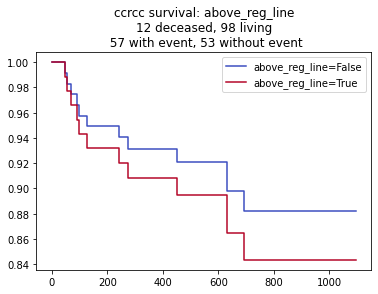

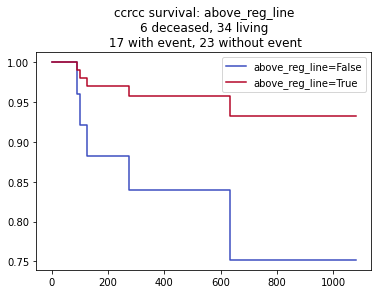

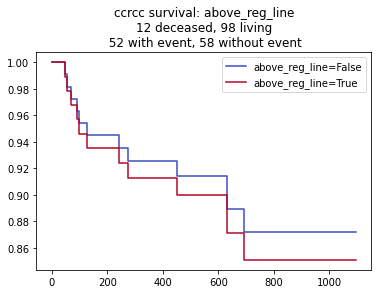

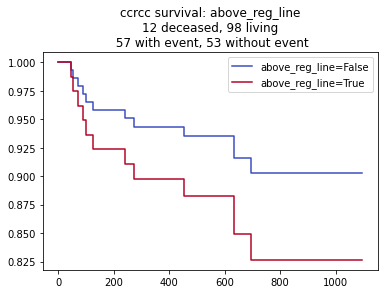

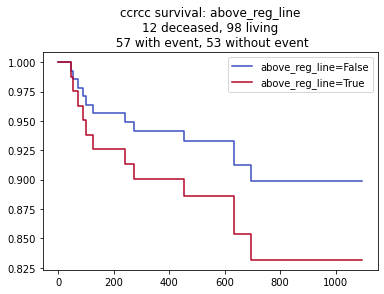

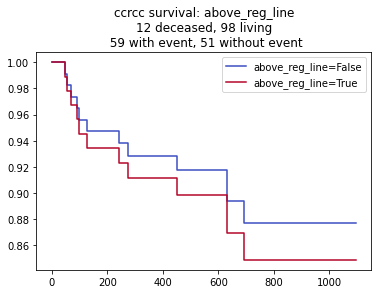

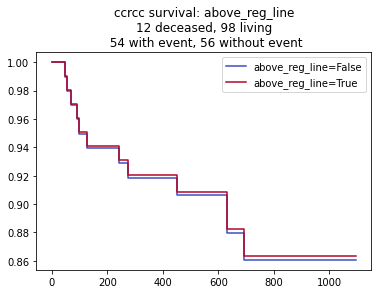

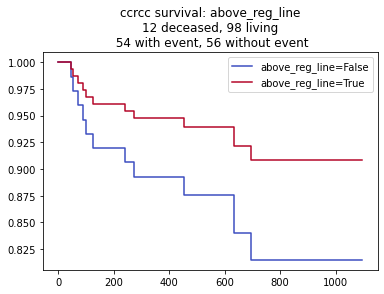

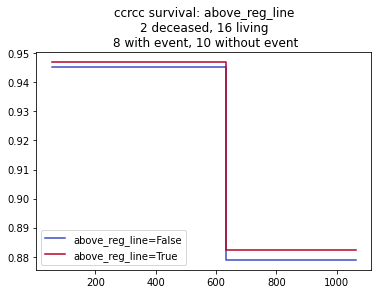

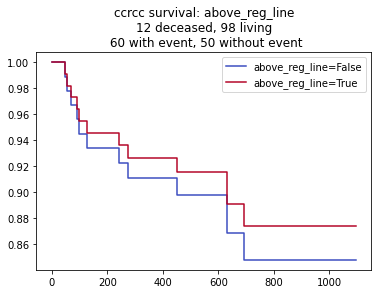

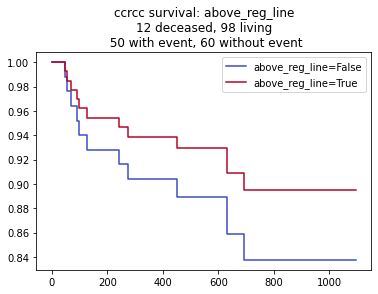

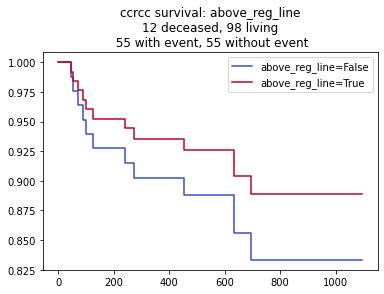

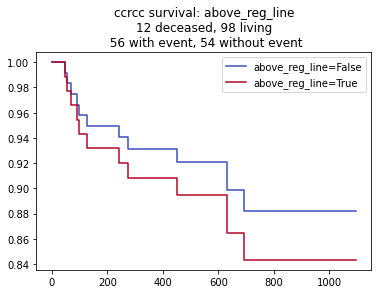

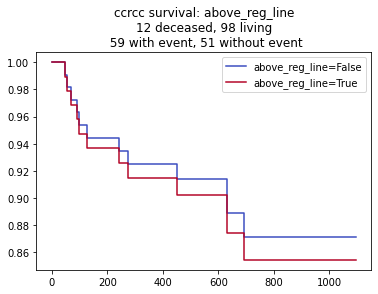

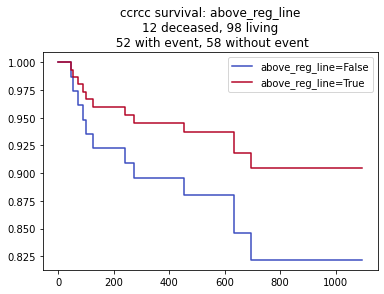

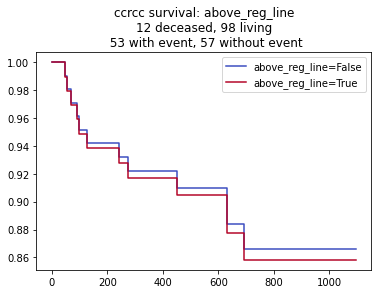

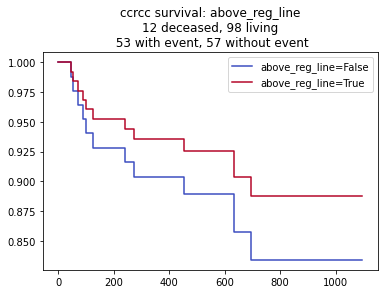

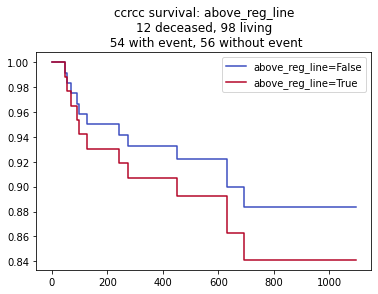

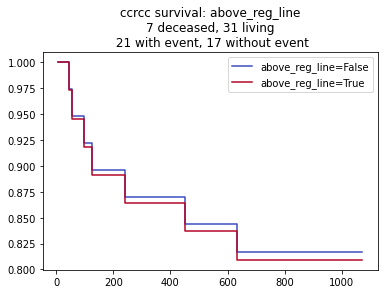

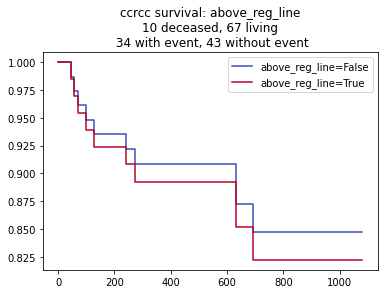

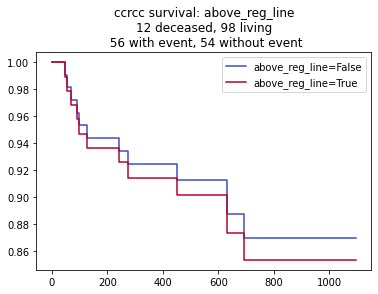

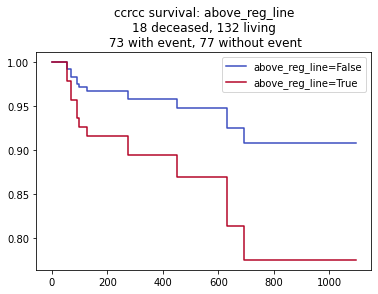

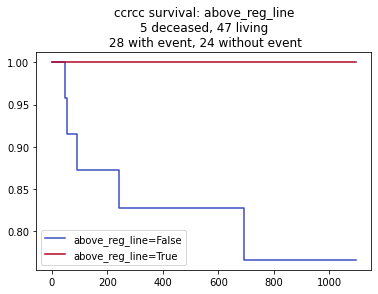

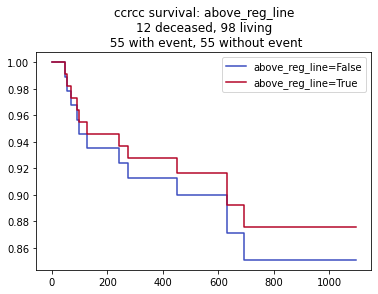

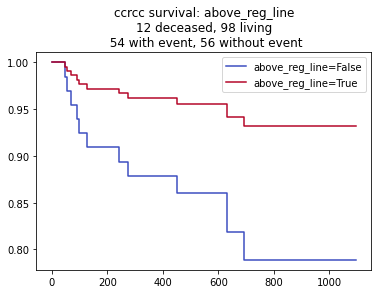

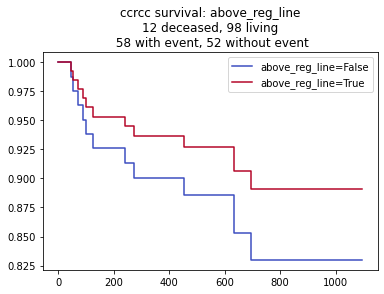

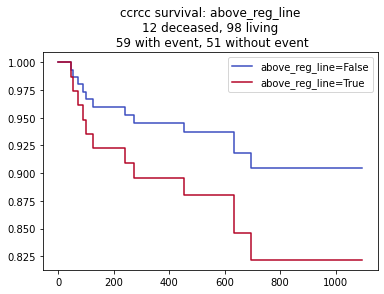

Error in callback <function flush_figures at 0x7fd91e3ecd30> (for post_execute):


KeyboardInterrupt: 

In [23]:
for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    for i,g in df.groupby(["Gene"]):
        sel_df = g[["death", "days_to_last_contact_or_death", "above_reg_line"]]
        plot_single_var_survival(cancer_type, sel_df, "above_reg_line", i)

## Plot multiple variables

In [16]:
def plot_multi_var_survival(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    print(cancer_type)
    cph.print_summary()
#     print(lifelines.statistics.proportional_hazard_test(cph, df))
    
    deceased_count = df["death"].sum()
    living_count = df["death"].size - deceased_count
    
    has_8p_loss = df["8p_loss"].sum()
    no_8p_loss = df["8p_loss"].size - has_8p_loss
    
    has_8q_gain = df["8q_gain"].sum()
    no_8q_gain = df["8q_gain"].size - has_8q_gain
    
    plot_title = f"{cancer_type} survival: Chromosome 8\n{deceased_count} deceased, {living_count} living" +\
        f"\n{has_8p_loss} with 8p_loss, {no_8p_loss} without" +\
        f"\n{has_8q_gain} with 8q_gain, {no_8q_gain} without"
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

hnscc                                     


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


<lifelines.CoxPHFitter: fitted with 95 total observations, 83 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 95
number of events observed = 12
   partial log-likelihood = -45.74
         time fit was run = 2020-10-08 04:11:29 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.54       0.58       0.58            -1.68             0.60                 0.19                 1.81
8q_gain     0.97       2.64       0.58            -0.17             2.11                 0.84                 8.28

              z    p   -log2(p)
covariate                      
8p_loss   -0.93 0.35       1.51
8q_gain    1.67 0.10       3.39
---
Concordance = 0.64
Partial AIC = 95.49
log-likelihood ratio test = 2.65 on 2 df
-log2(p) of ll-ratio test = 1.91

luad                                     


<lifelines.CoxPHFitter: fitted with 99 total observations, 85 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 99
number of events observed = 14
   partial log-likelihood = -56.02
         time fit was run = 2020-10-08 04:11:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss    -0.90       0.40       0.78            -2.44             0.63                 0.09                 1.88
8q_gain     0.20       1.23       0.70            -1.16             1.57                 0.31                 4.81

              z    p   -log2(p)
covariate                      
8p_loss   -1.16 0.25       2.01
8q_gain    0.29 0.77       0.38
---
Concordance = 0.59
Partial AIC = 116.04
log-likelihood ratio test = 1.57 on 2 df
-log2(p) of ll-ratio test = 1.14

ovarian                                     


<lifelines.CoxPHFitter: fitted with 97 total observations, 90 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'death'
          robust variance = True
      baseline estimation = breslow
   number of observations = 97
number of events observed = 7
   partial log-likelihood = -19.83
         time fit was run = 2020-10-08 04:11:57 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
8p_loss     0.50       1.66       0.74            -0.95             1.95                 0.39                 7.05
8q_gain     1.43       4.16       0.88            -0.30             3.16                 0.74                23.47

             z    p   -log2(p)
covariate                     
8p_loss   0.68 0.50       1.01
8q_gain   1.61 0.11       3.23
---
Concordance = 0.64
Partial AIC = 43.66
log-likelihood ratio test = 3.57 on 2 df
-log2(p) of ll-ratio test = 2.58

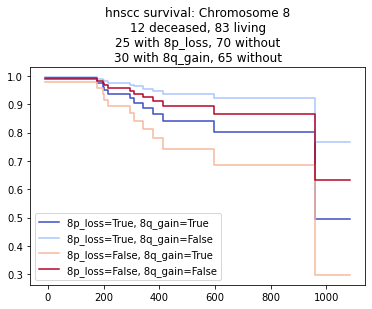

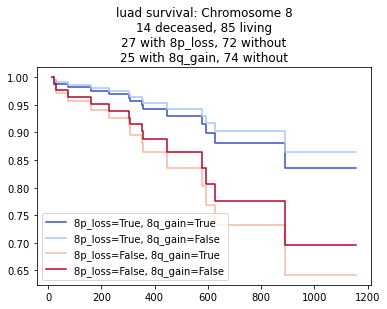

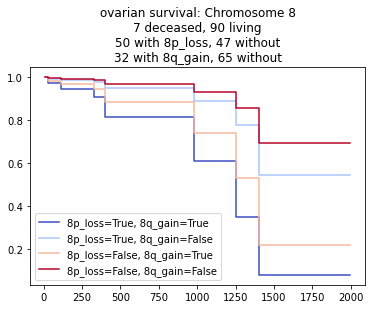

In [17]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    plot_multi_var_survival(cancer_type, df, cnv_cols)

## Plot confidence intervals

In [9]:
def plot_cis(cancer_type, df):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot(ax=plt.axes(label=cancer_type))

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


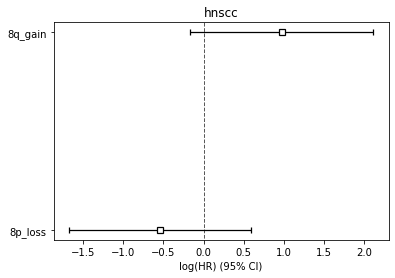

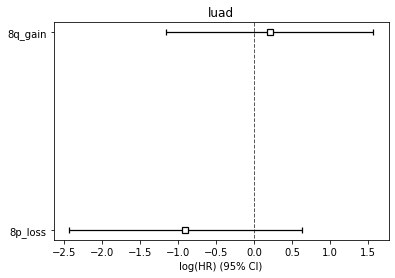

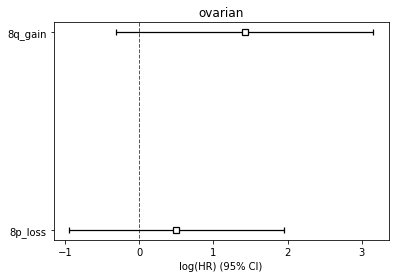

In [10]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    ax = plot_cis(cancer_type, df)
    ax.set_title(cancer_type)
    plt.show()

## Calculate P values for proportional hazard test

In [11]:
def calc_pvals(cancer_type, df, cnv_cols):
    
    cph = CoxPHFitter()
    cph.fit(
        df=df, 
        duration_col="days_to_last_contact_or_death",
        event_col="death",
        robust=True
    )
    
    return cph.plot_partial_effects_on_outcome(
        covariates=cnv_cols, 
        values=[[a, b] for a in [True, False] for b in [True, False]],
        plot_baseline=False,
        cmap='coolwarm', 
        title=plot_title
    )

In [12]:
cnv_cols = ["8p_loss", "8q_gain"]

for cancer_type, ds in dss.items():
    df = prepare_plot_table(ds)
    df = df[["death", "days_to_last_contact_or_death", ] + cnv_cols]
    calc_pvals(cancer_type, df, cnv_cols)

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/home/caleb/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 4)


NameError: name 'plot_title' is not defined

### Where are the date of inital diagnosis columns for BRCA and Colon?

In [ ]:
br = cptac.Brca()

In [ ]:
co = cptac.Colon()

In [ ]:
pd.options.display.max_columns = None

In [ ]:
br.get_followup()

In [ ]:
co.get_followup()